In [171]:
import datetime

In [172]:
import numpy as np
import pandas as pd

In [173]:
import matplotlib.pyplot as plt

In [174]:
%matplotlib inline

In [ ]:
# from jupyterthemes import jtplot
# jtplot.style()

In [175]:
train_data = pd.read_csv('data/in/train.csv').fillna('NaN').drop(columns=['Id'])
test_data = pd.read_csv('data/in/test.csv').fillna('NaN')

In [176]:
start_training = pd.to_datetime('2020-01-19')
train_up_to = pd.to_datetime('2020-03-25')
public_test_up_to = pd.to_datetime('2020-04-08')

In [177]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

public_mask = np.logical_and(start_training < train_data['Date'],
                             train_data['Date'] <= train_up_to)
validation_mask = train_up_to < train_data['Date']

# train_data = train_data
train_data.loc[:, ('ConfirmedCases', 'Fatalities')] = train_data[['ConfirmedCases', 'Fatalities']] \
#                                                      .apply(lambda x: np.log1p(x))
# train_data.replace([np.inf, -np.inf], 0, inplace=True)

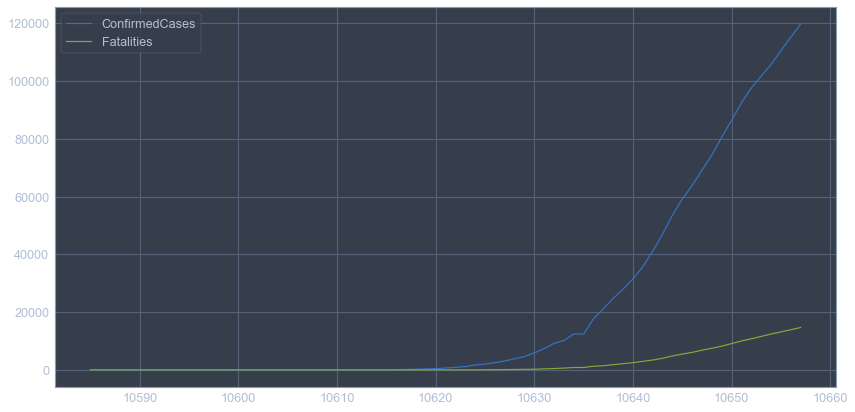

In [178]:
country = 'Italy'
train_data[train_data.Country_Region=='Italy'][['ConfirmedCases', 'Fatalities']].plot(figsize=(14, 7)) 

In [179]:
train_data.loc[public_mask, 'ForecastId'] = -1
train_data.loc[validation_mask, 'ForecastId'] = 0

test_data['ConfirmedCases'] = 0.0
test_data['Fatalities'] = 0.0

In [249]:
def get_lags(df, columns, lags=10):
    dfs = []
    for i in range(lags):
        lag_df = df[columns].shift(i + 1, fill_value=0)
        lag_df = lag_df.rename(lambda x: x + f'_{i}', axis=1)
        dfs.append(lag_df)
    
    return pd.concat([df] + dfs, axis=1)

In [181]:
from sklearn.preprocessing import LabelEncoder

In [192]:
data = pd.concat([train_data, test_data], ignore_index=True)
def get_masks(df): 
    train_mask = data['ForecastId'] == -1
    validation_mask = data['ForecastId'] == 0
    test_mask = data['ForecastId'] > 0
    return train_mask, validation_mask, test_mask

train_mask, validation_mask, test_mask = get_masks(data)

In [193]:
def add_time_features(data):
    le = LabelEncoder()
    data['Day_num'] = le.fit_transform(data.Date)
    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    return data

data = add_time_features(data)

In [194]:
data[train_mask].head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month
0,NaN,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1
1,NaN,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1
2,NaN,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1
3,NaN,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1
4,NaN,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1


In [195]:
data[validation_mask].head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month
64,NaN,Afghanistan,2020-03-26,94.0,4.0,0.0,64,26,3
65,NaN,Afghanistan,2020-03-27,110.0,4.0,0.0,65,27,3
66,NaN,Afghanistan,2020-03-28,110.0,4.0,0.0,66,28,3
67,NaN,Afghanistan,2020-03-29,120.0,4.0,0.0,67,29,3
68,NaN,Afghanistan,2020-03-30,170.0,4.0,0.0,68,30,3


In [196]:
data[test_mask].head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month
22338,NaN,Afghanistan,2020-03-26,0.0,0.0,1.0,64,26,3
22339,NaN,Afghanistan,2020-03-27,0.0,0.0,2.0,65,27,3
22340,NaN,Afghanistan,2020-03-28,0.0,0.0,3.0,66,28,3
22341,NaN,Afghanistan,2020-03-29,0.0,0.0,4.0,67,29,3
22342,NaN,Afghanistan,2020-03-30,0.0,0.0,5.0,68,30,3


## ML Brute-force

In [197]:
import seaborn as sns
import math

In [198]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, log_loss, hinge_loss, f1_score, precision_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [199]:
import warnings
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import tree
import warnings

warnings.filterwarnings("ignore")

In [200]:
from tqdm import tqdm_notebook as tqdm

In [201]:
def train_models(X_train, y_confirmed, y_fatalities):
    tscv = TimeSeriesSplit(n_splits=3) 
    for row_index, clf in enumerate(ML_methods):
        clf_confirmed = clf()
        clf_fatalities = clf()
        
        confirmed_cv_results = model_selection.cross_validate(
            clf_confirmed, X_train, y_confirmed, cv=tscv, scoring='neg_mean_squared_error')
        fatalities_cv_results = model_selection.cross_validate(
            clf_fatalities, X_train, y_fatalities, cv=tscv, scoring='neg_mean_squared_error')

        ML_name = clf_confirmed.__class__.__name__
        ML_compare.loc[row_index, 'Name'] = ML_name
        ML_compare.loc[row_index, 'Parameters'] = str(clf.get_params)
        
        ML_compare.loc[row_index, 'Confirmed Time'] = confirmed_cv_results['fit_time'].mean()
        ML_compare.loc[row_index, 'Fatalities Time'] = fatalities_cv_results['fit_time'].mean()
        
        ML_compare.loc[row_index, 'Confirmed Test Error Mean'] = -1 * \
                                    confirmed_cv_results['test_score'].mean()
        ML_compare.loc[row_index, 'Fatalities Test Error Mean'] = -1 * \
                                    fatalities_cv_results['test_score'].mean()
        ML_compare.loc[row_index, 'Confirmed Test Error 3*STD'] = 3 * \
                                    confirmed_cv_results['test_score'].std()
        ML_compare.loc[row_index, 'Fatalities Test Error 3*STD'] = 3 * \
                                    fatalities_cv_results['test_score'].std()


        clf_confirmed = clf_confirmed.fit(X_train, y_confirmed)
        clf_fatalities = clf_fatalities.fit(X_train, y_fatalities)
        
#         ML_predict[ML_name] = (np.expm1(clf_confirmed.predict(X_train)), 
#                                np.expm1(clf_fatalities.predict(X_train)))
        
    return ML_compare, ML_predict

In [240]:
def aggregate_by_date(df):
    return df.groupby('Date', as_index=False) \
                       .agg({'Fatalities': 'sum', 'ConfirmedCases':'sum'})

In [325]:
def predict(test_df, model):
    lags_queue = deque(test_df.iloc[0, -20:], maxlen=20)
    res = []
    for i, df_row in test_df.iterrows():
        X_test = df_row[['Day_num', 'Day', 'Month']].to_numpy().tolist()
        X_test = np.array([X_test + list(lags_queue)])
        
        y_pred =  model.predict(X_test).flatten()
        
        lags_queue.appendleft(y_pred[1])
        lags_queue.appendleft(y_pred[0])

        res.append(y_pred)
    
    return res

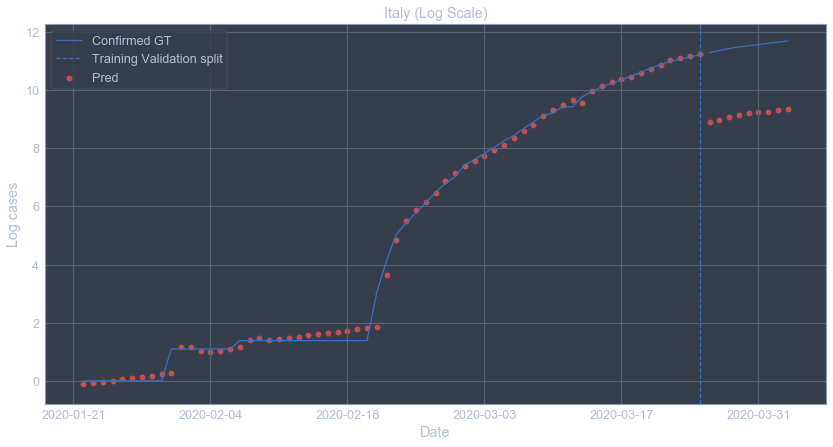

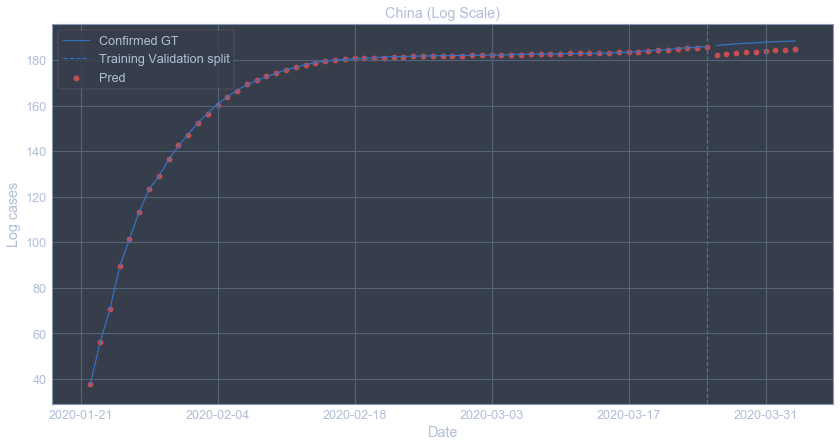

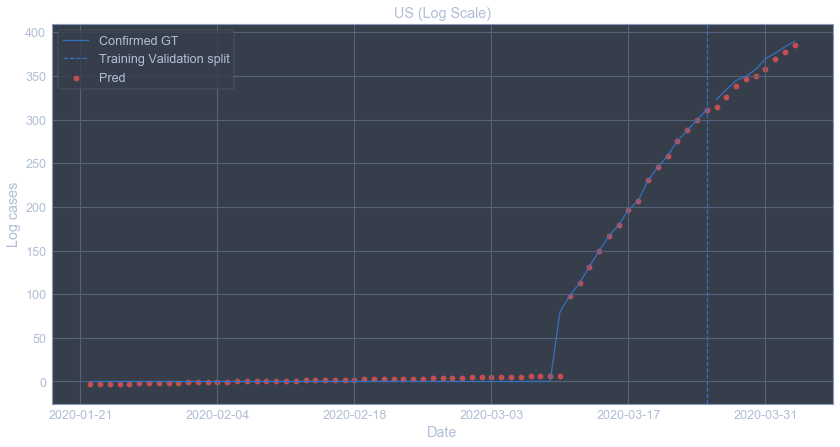

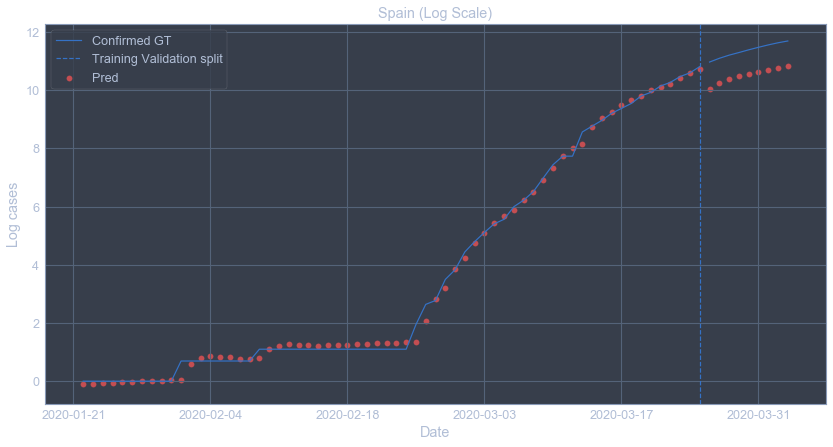

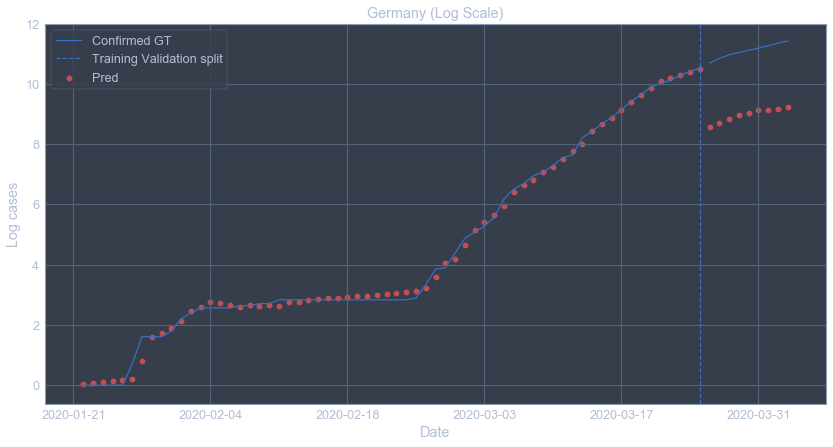

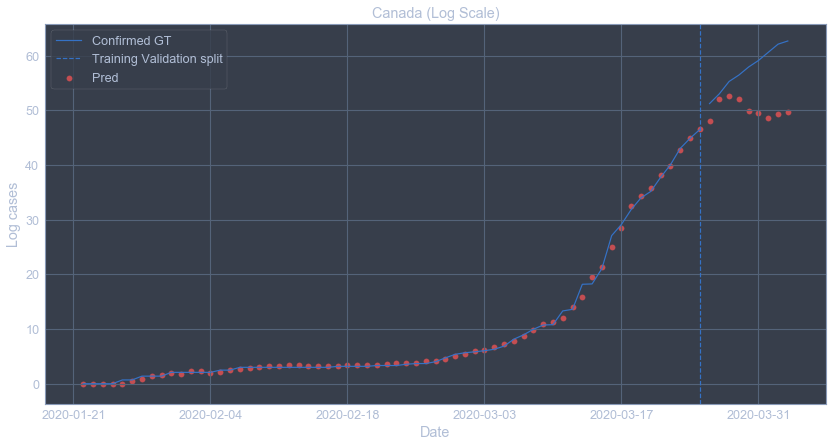

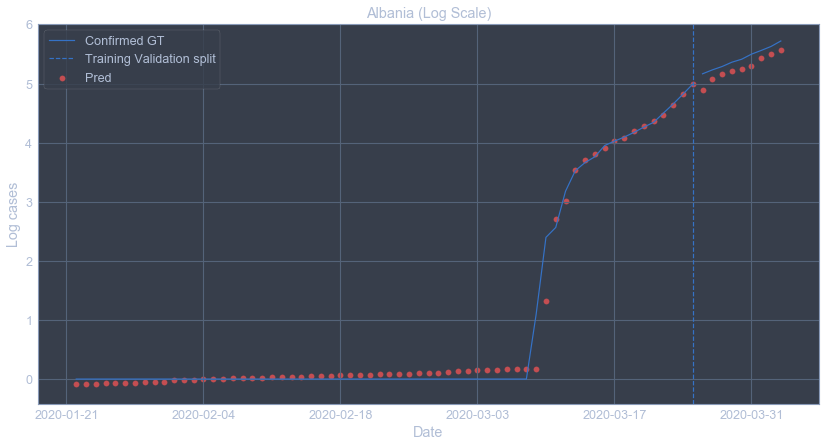

In [343]:
columns_to_drop = ['Date', 'ConfirmedCases', 'Fatalities']
train_mask, val_mask, test_mask = get_masks(data)
for country in tqdm(['Italy', 'China', 'US', 'Spain', 'Germany', 'Canada', 'Albania']):
    model = linear_model.Ridge()
    country_mask = data['Country_Region'] == country

    country_train_mask = train_mask & country_mask
    country_val_mask = val_mask & country_mask
    country_test_mask = test_mask & country_mask
    
    data_log = data.copy()
    data_log[['ConfirmedCases', 'Fatalities']] = np.log1p(data_log[['ConfirmedCases', 'Fatalities']])
    country_train_data = add_time_features(aggregate_by_date(data_log[country_train_mask]))
    country_val_data   = add_time_features(aggregate_by_date(data_log[country_val_mask]))
    country_test_data  = add_time_features(aggregate_by_date(data_log[country_test_mask]))
        
    lags = get_lags(pd.concat([country_train_data, country_val_data], ignore_index=True), 
                    ['ConfirmedCases', 'Fatalities'])
    
    country_train_data = lags.iloc[:len(country_train_data)]
    country_val_data = lags.iloc[len(country_train_data):]
        
    y_confirmed = country_train_data['ConfirmedCases'].to_numpy()
    y_fatalities = country_train_data['Fatalities'].to_numpy()
    
    X_train = country_train_data.drop(columns=columns_to_drop).to_numpy()
    X_val = country_val_data.drop(columns=columns_to_drop).to_numpy()
    y_train = np.stack((y_confirmed, y_fatalities), axis=1)
    
    model = model.fit(X_train, y_train)
    y_pred_train = pd.DataFrame(data=model.predict(X_train), 
                              columns=['ConfirmedCases', 'Fatalities'],
                              index = country_train_data['Date'])
    

#     y_pred_val = predict(country_val_data, model) # predicts using its own predictions
    y_pred_val = model.predict(X_val) # predicts using gt data (unfair)
    y_pred_val = pd.DataFrame(data=y_pred_val, 
                              columns=['ConfirmedCases', 'Fatalities'],
                              index = country_val_data['Date'])
    
    plt.figure(figsize=(14, 7))
    plt.plot(country_train_data['Date'], 
             country_train_data['ConfirmedCases'].values, c='b', label='')
    
    plt.plot(country_val_data['Date'], 
             country_val_data['ConfirmedCases'], c='b', label='Confirmed GT',)
    
    plt.scatter(country_train_data['Date'], y_pred_train['ConfirmedCases'], c='r', label='')
    plt.scatter(country_val_data['Date'], y_pred_val['ConfirmedCases'], c='r', label='Pred')

    plt.axvline(train_up_to, linestyle='--', label='Training Validation split')
    plt.legend()
    plt.title(country +' (Log Scale)')
    plt.ylabel('Log cases')
    plt.xlabel('Date')
    plt.show()

## NOT USED

In [36]:
# from collections import deque

In [37]:
# def predict(test_df, confirmed_model, fatalities_model):
#     lags_queue = deque(test_df.iloc[0, -20:], maxlen=20)
#     y_pred_confirmed = []
#     y_pred_fatalities = []
#     for i, df_row in test_df.iterrows():
#         X_test = df_row[['Day_num', 'Day', 'Month']].to_numpy().tolist()
#         X_test = np.array([X_test + list(lags_queue)])
        
#         confirmed_pred =  confirmed_model.predict(X_test).flatten()
#         fatalities_pred = fatalities_model.predict(X_test).flatten()
        
#         lags_queue.appendleft(fatalities_pred)
#         lags_queue.appendleft(confirmed_pred)

#         y_pred_confirmed.append(confirmed_pred)
#         y_pred_fatalities.append(fatalities_pred)
    
#     return y_pred_confirmed, y_pred_fatalities

In [42]:
# confirmed_model = linear_model.Ridge()
# fatalities_model = linear_model.Ridge()

# for country in tqdm(data['Country_Region'].unique()):
#     country_df = data.loc[data['Country_Region'] == country]
#     for state in country_df['Province_State'].unique():
#         curr_state_mask = np.logical_and(data['Country_Region'] == country, data['Province_State'] == state)
#         curr_state_data = data.loc[curr_state_mask]
        
#         lags_data = lagging(curr_state_data[['ConfirmedCases', 'Fatalities']])
#         data_with_lags = pd.concat([curr_state_data, lags_data], axis=1).dropna()
#         state_train_mask = data_with_lags['ForecastId'] == -1
        
#         state_train_data = data_with_lags[state_train_mask]
#         state_test_data = data_with_lags[~state_train_mask]
        
#         submission_df = pd.DataFrame({'ForecastId': state_test_data['ForecastId']})
        
#         y_confirmed = state_train_data['ConfirmedCases'].to_numpy()
#         y_fatalities = state_train_data['Fatalities'].to_numpy()
        
#         X_train = state_train_data.drop(columns=columns_to_drop + ['ForecastId']).to_numpy()
#         X_test = state_test_data.drop(columns=columns_to_drop + ['ForecastId']).to_numpy()
        
#         confirmed_model = confirmed_model.fit(X_train, y_confirmed)
#         fatalities_model = fatalities_model.fit(X_train, y_fatalities)

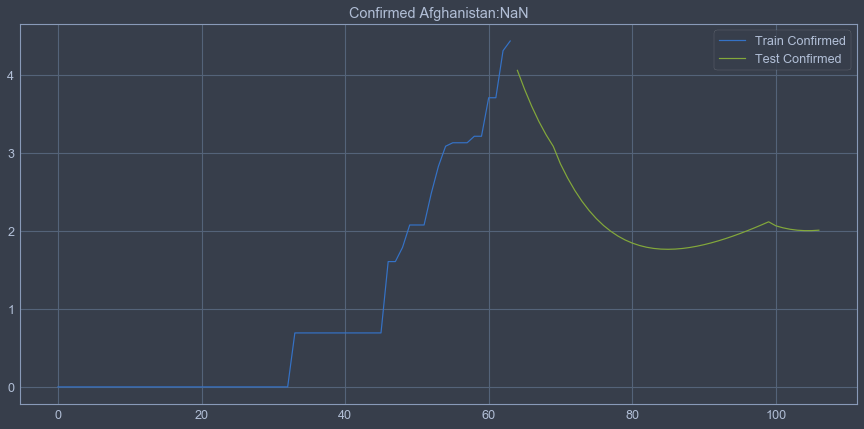

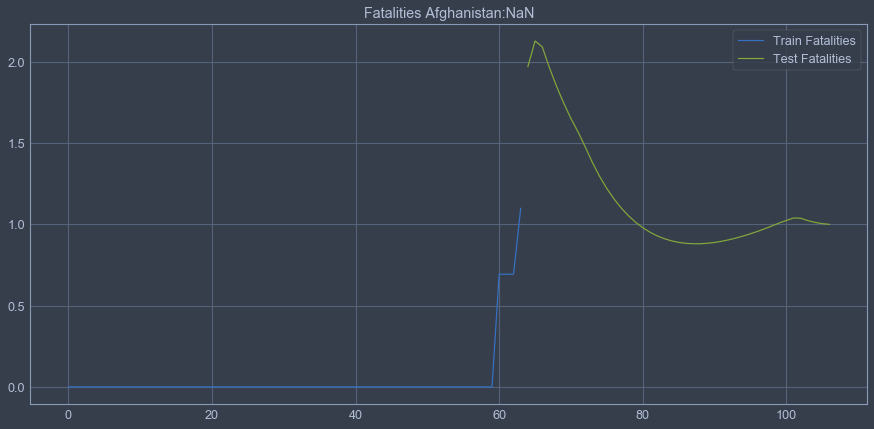

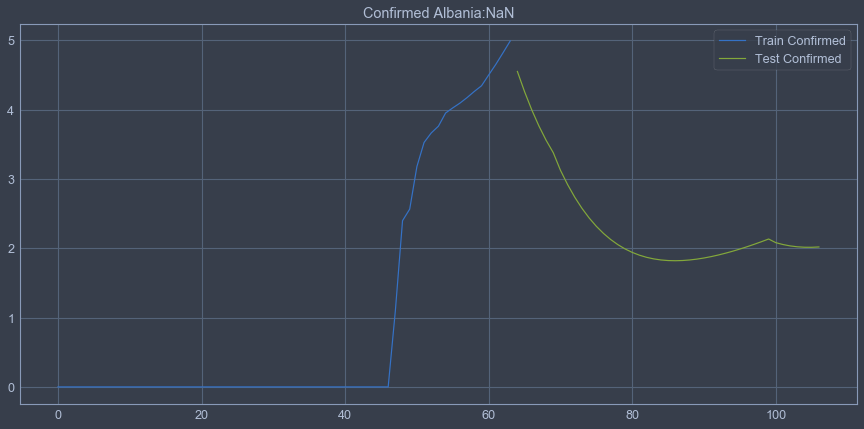

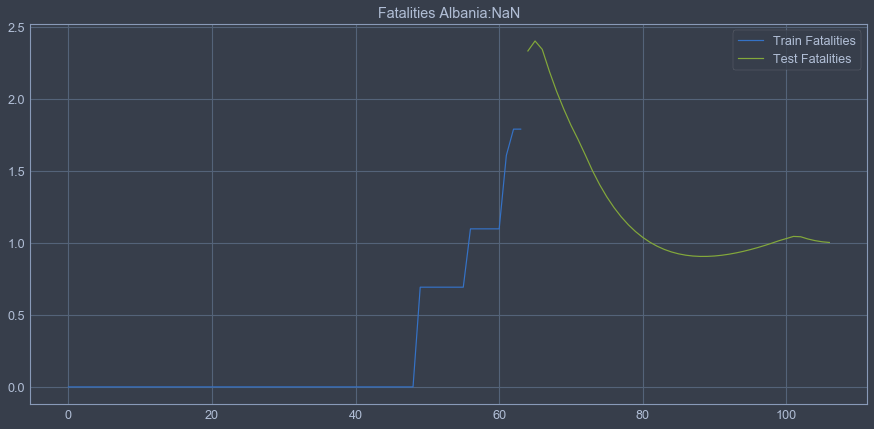

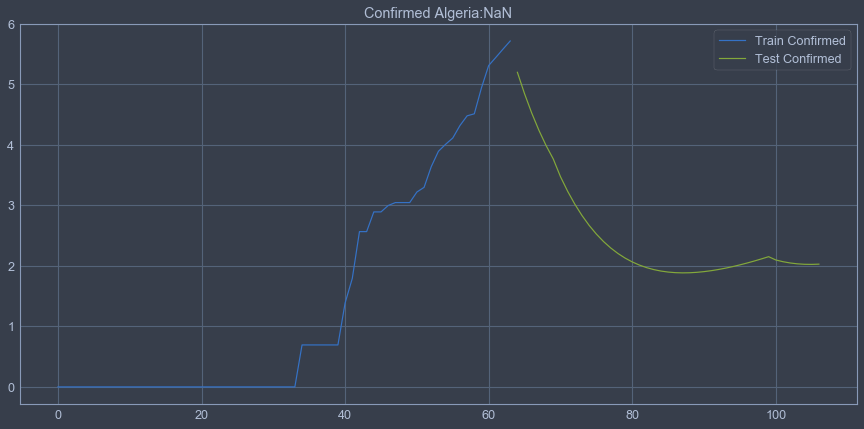

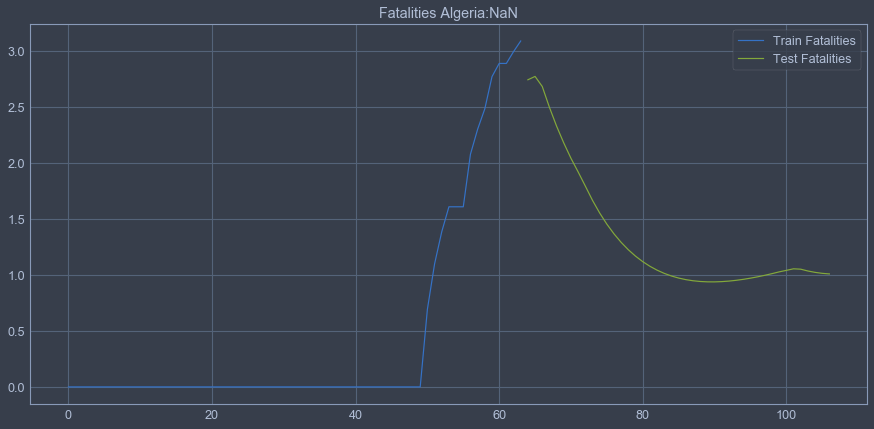

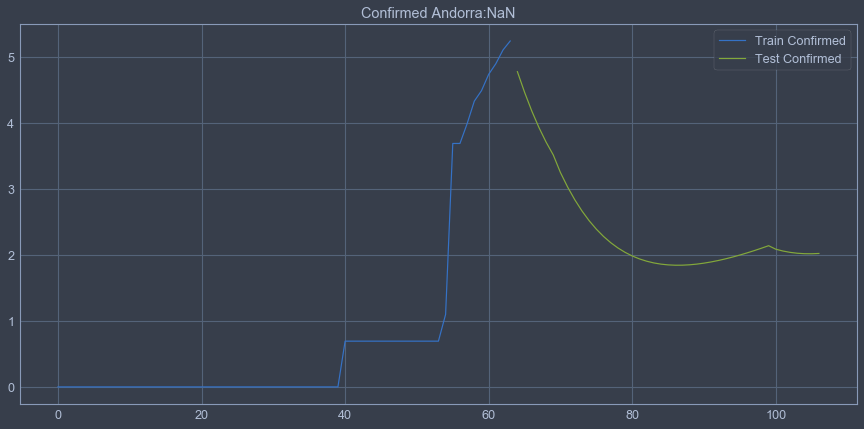

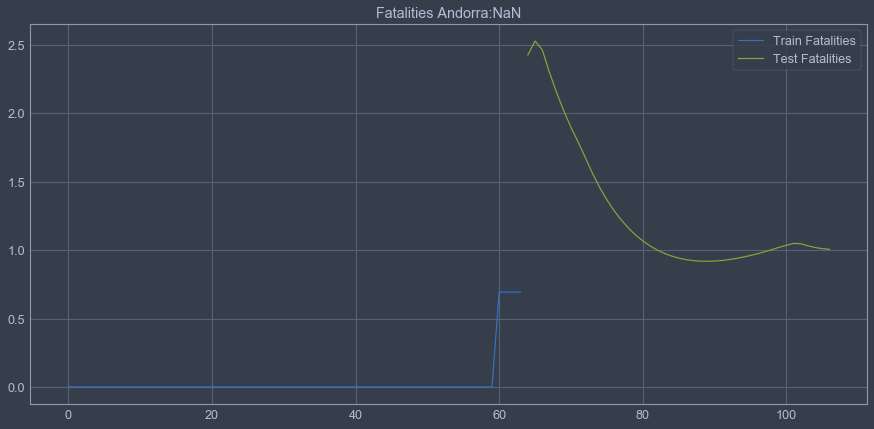

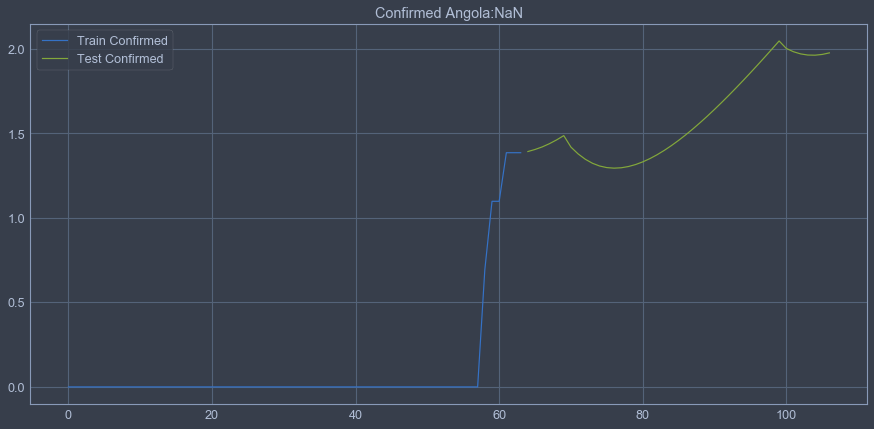

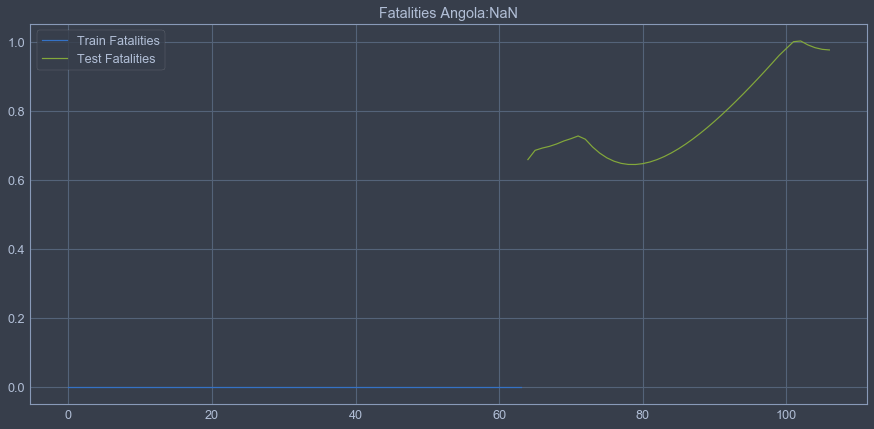

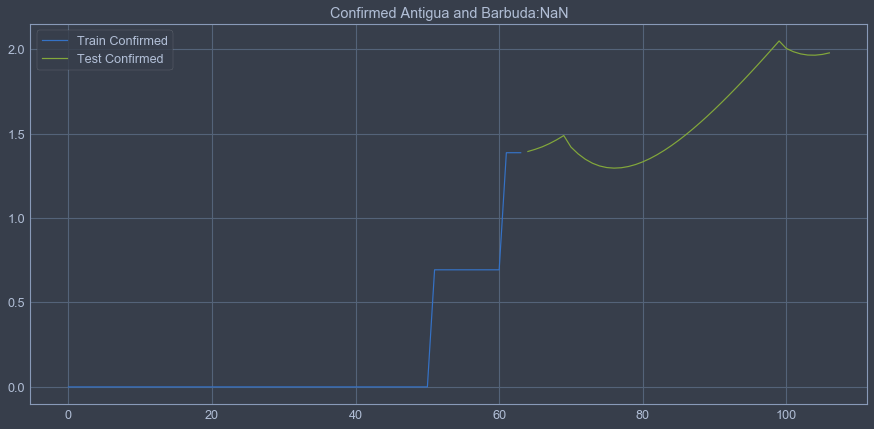

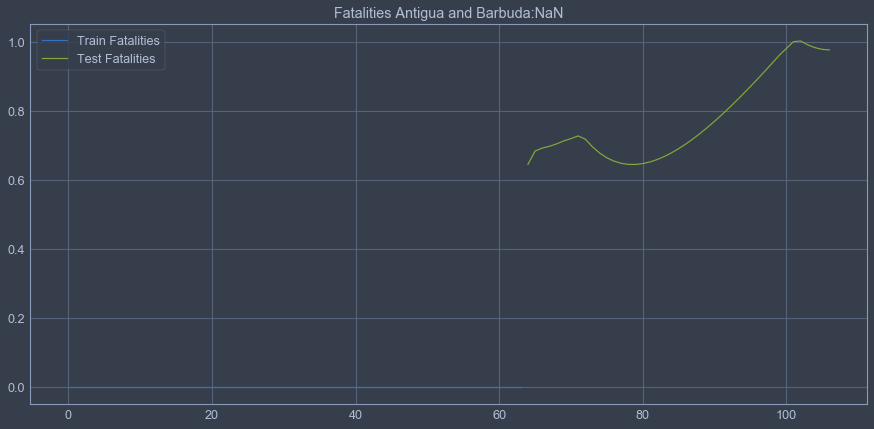

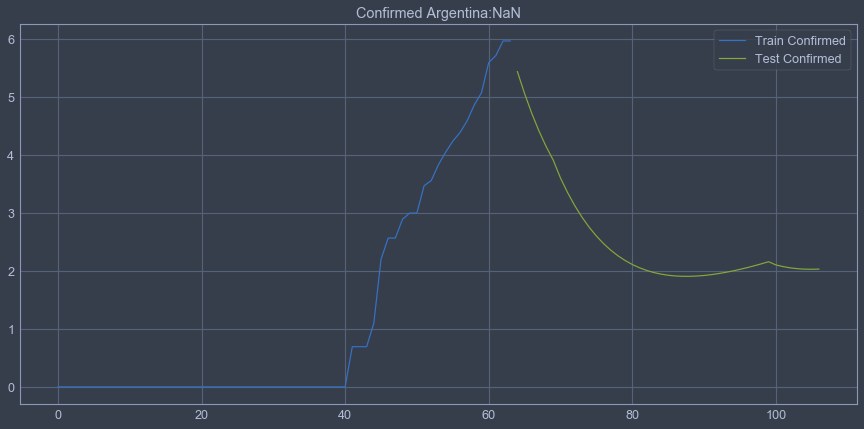

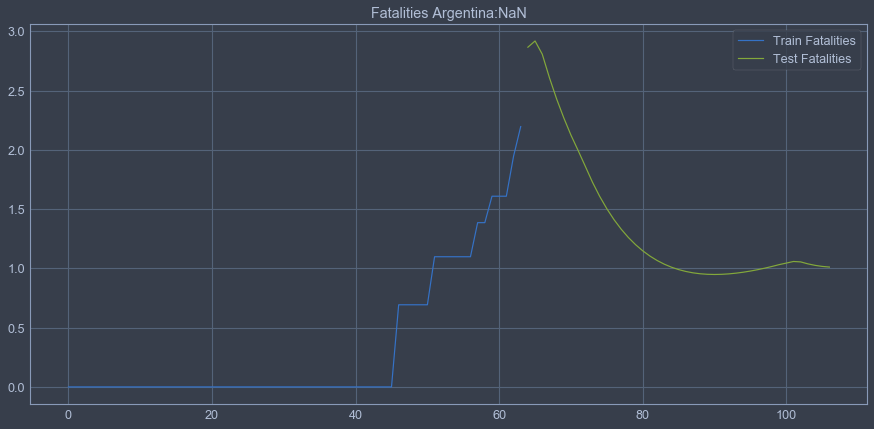

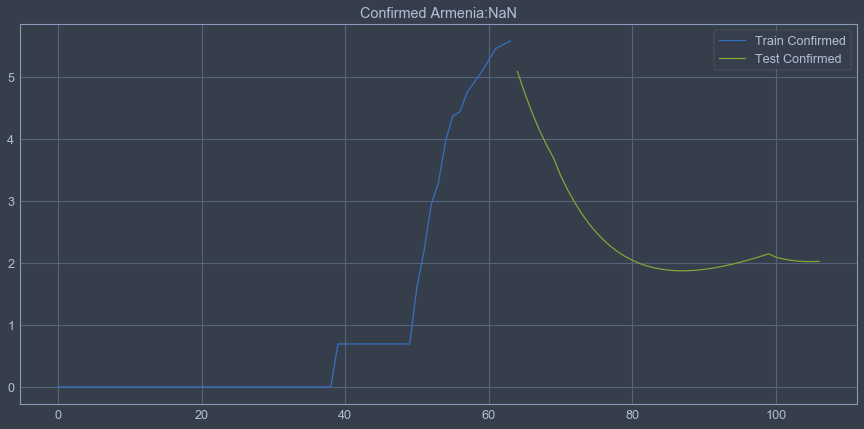

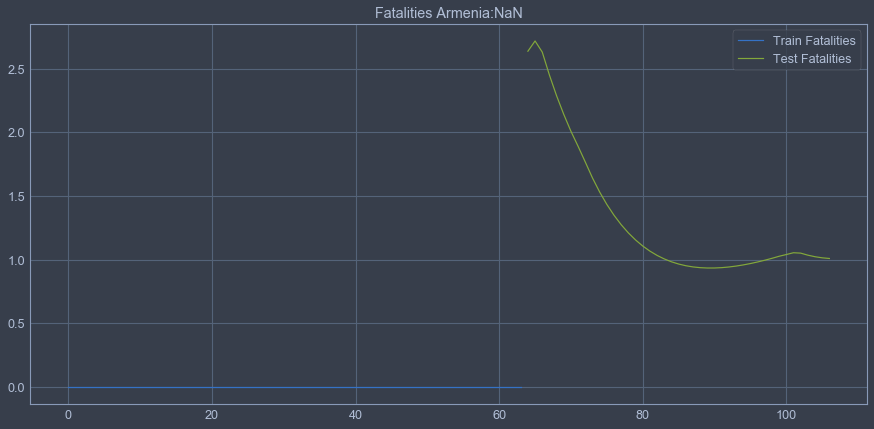

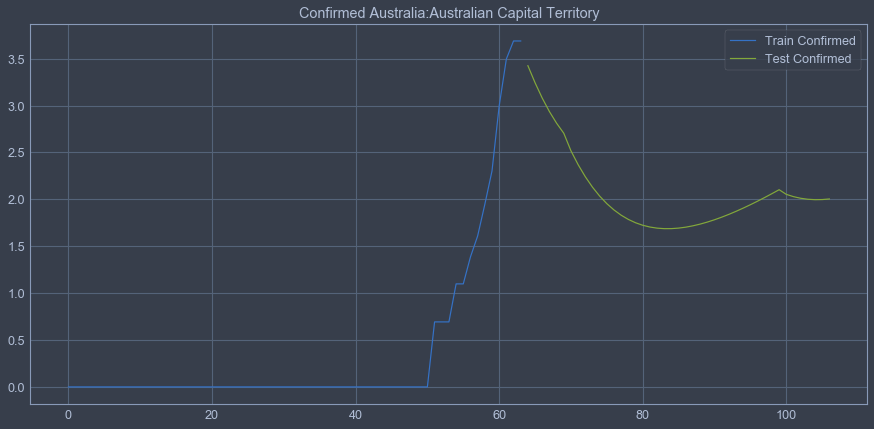

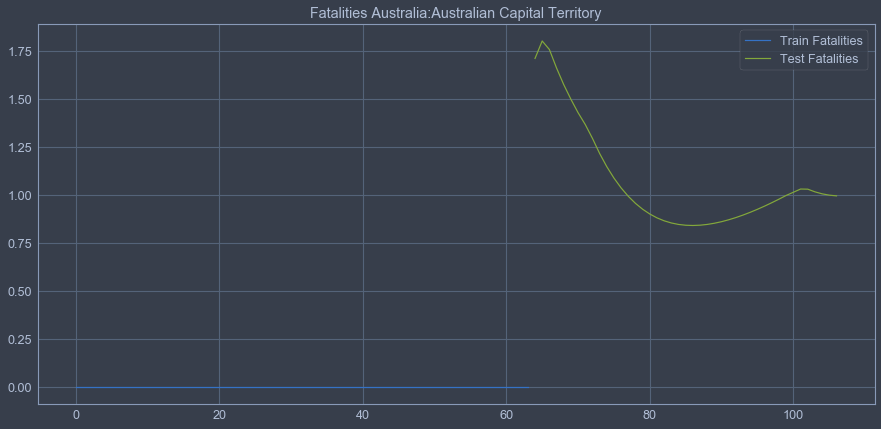

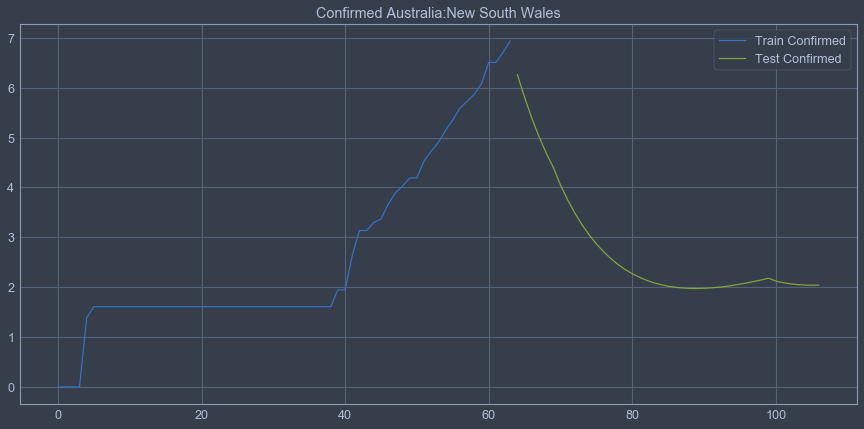

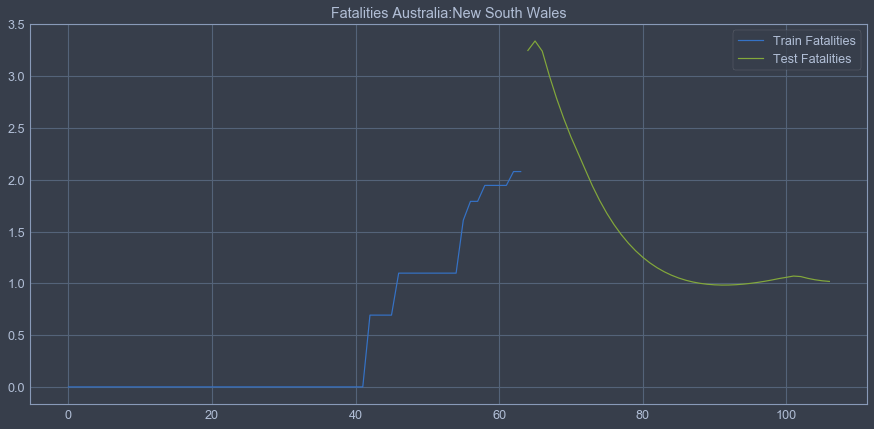

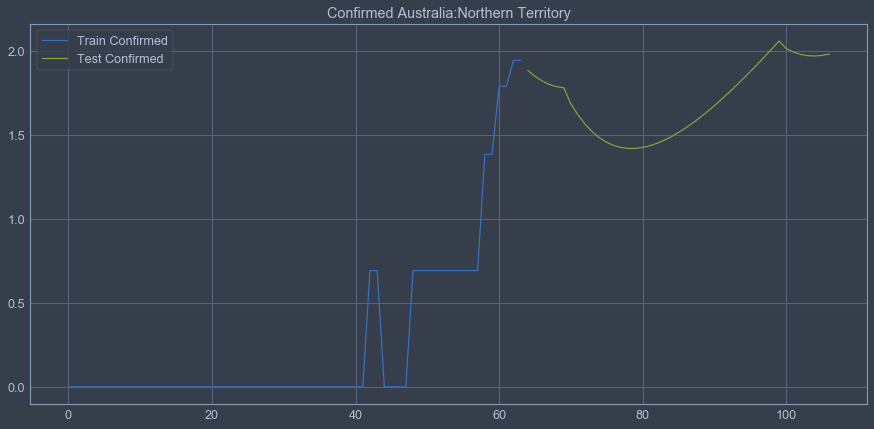

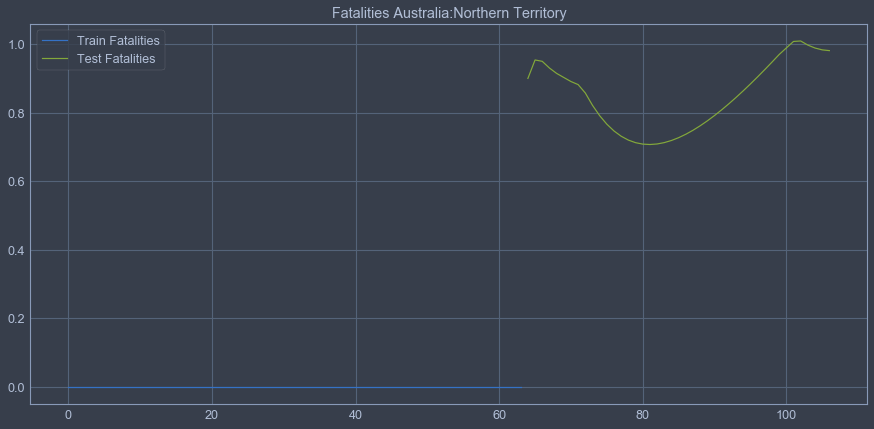

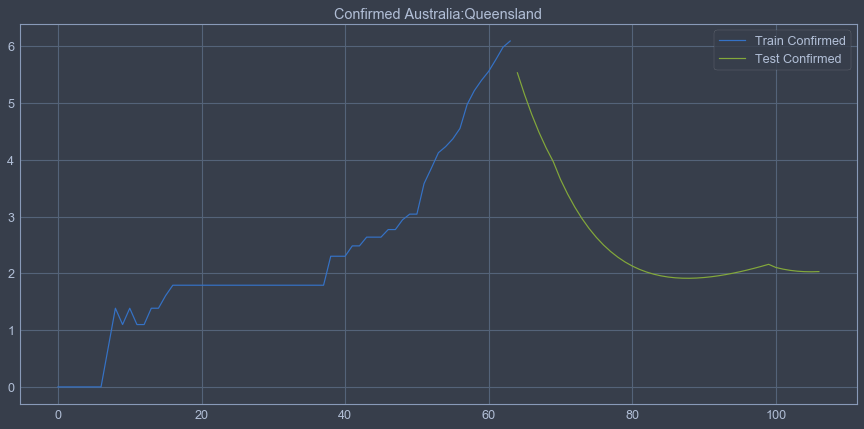

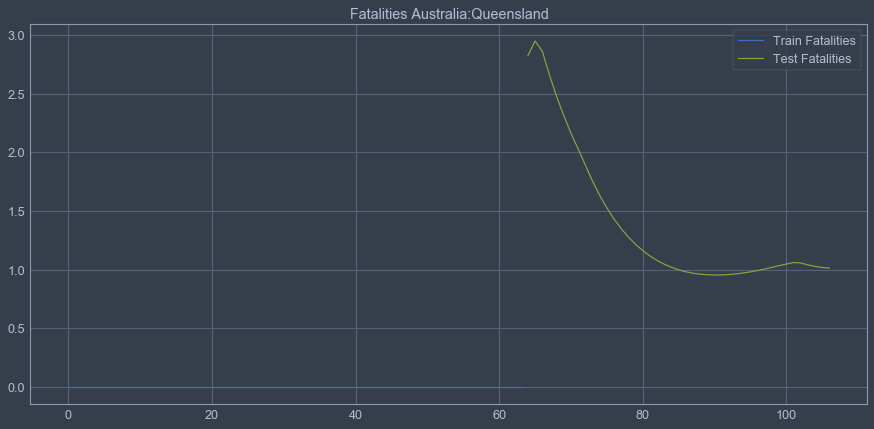

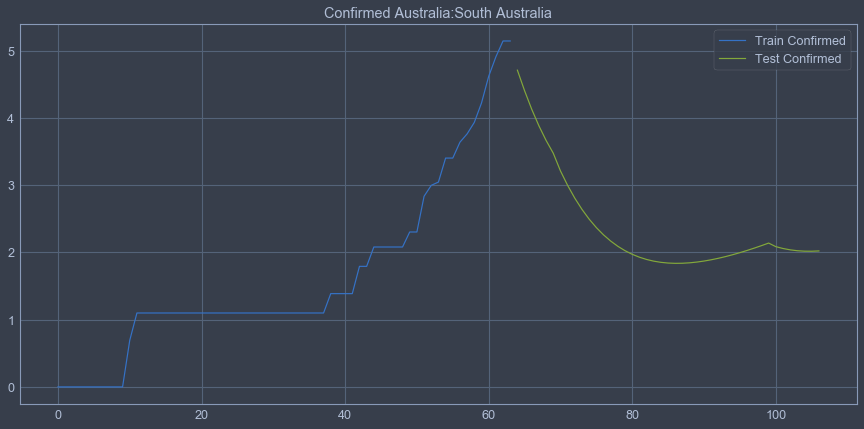

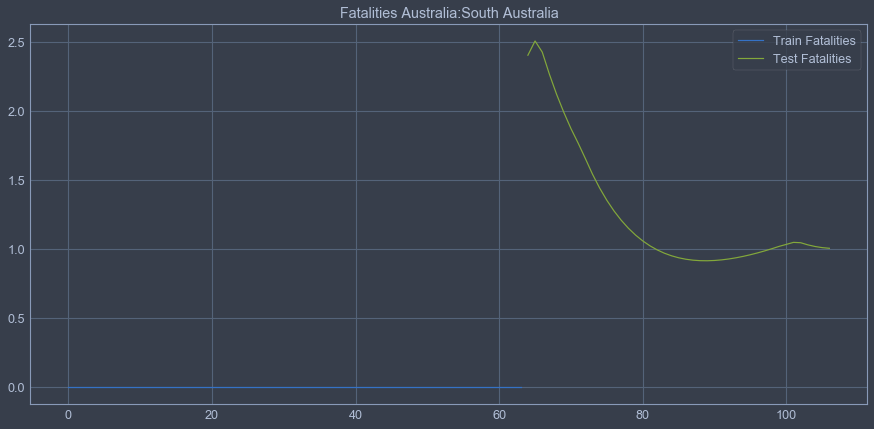

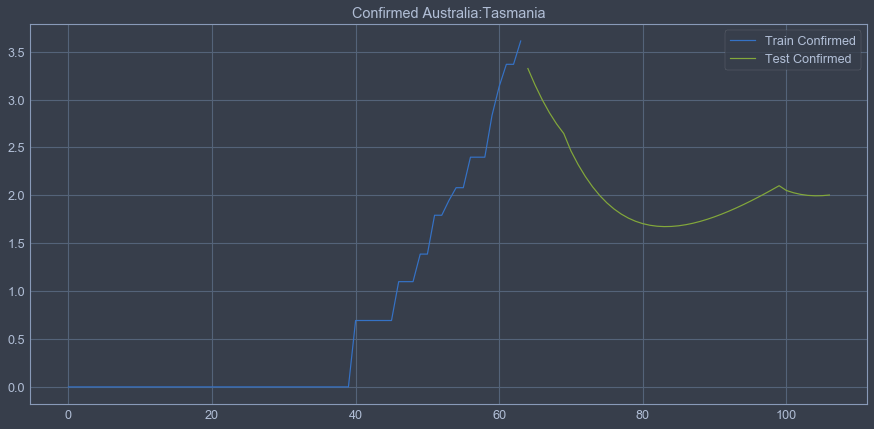

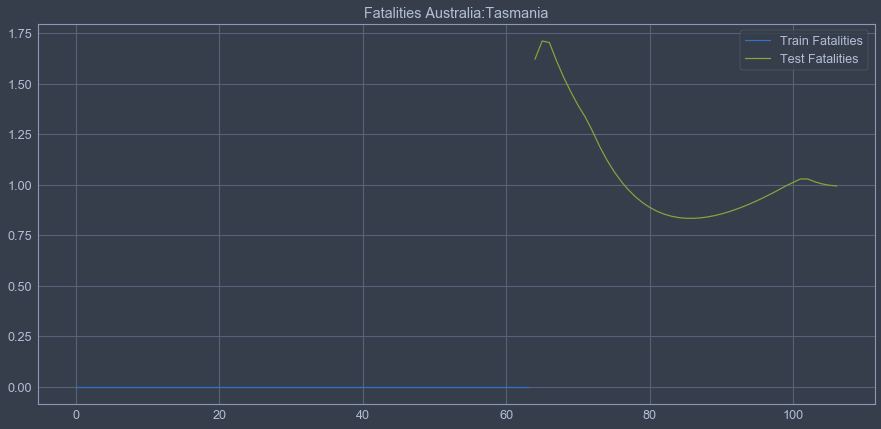

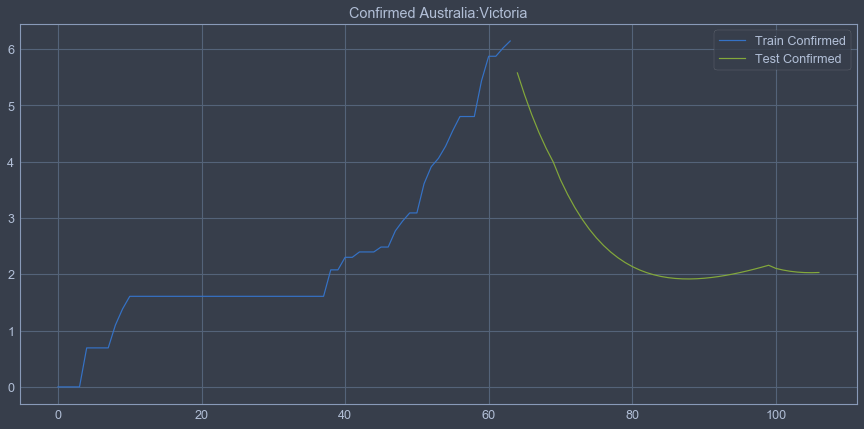

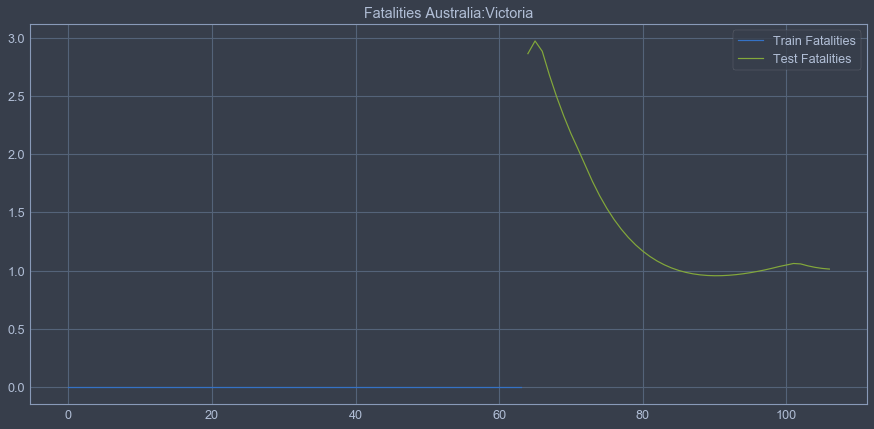

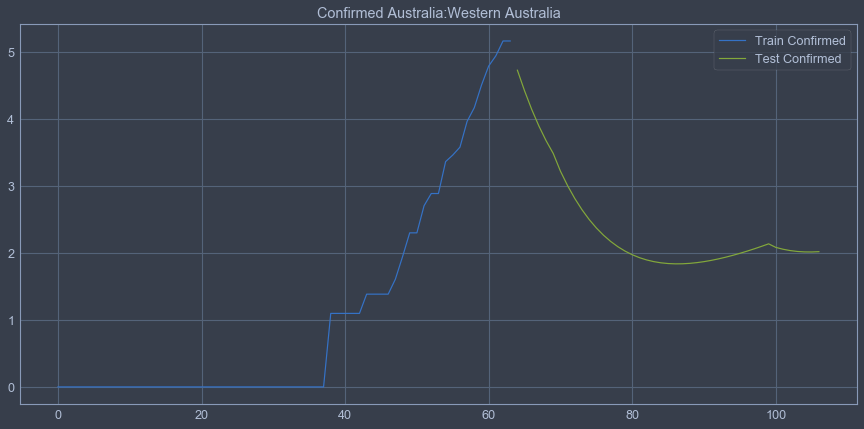

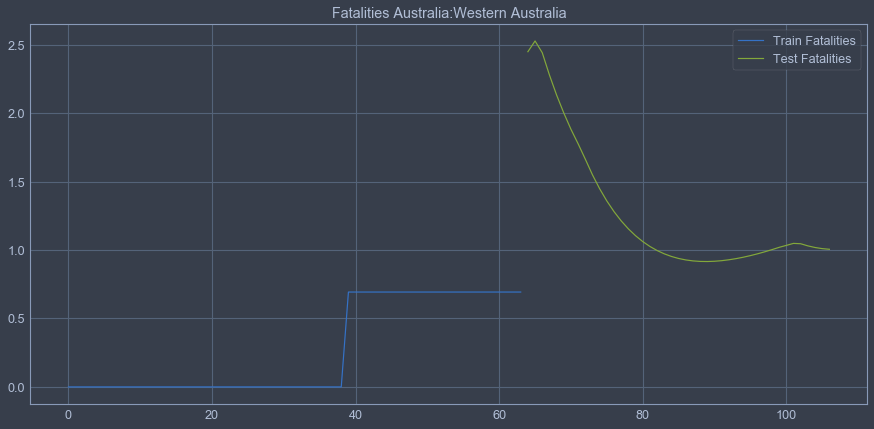

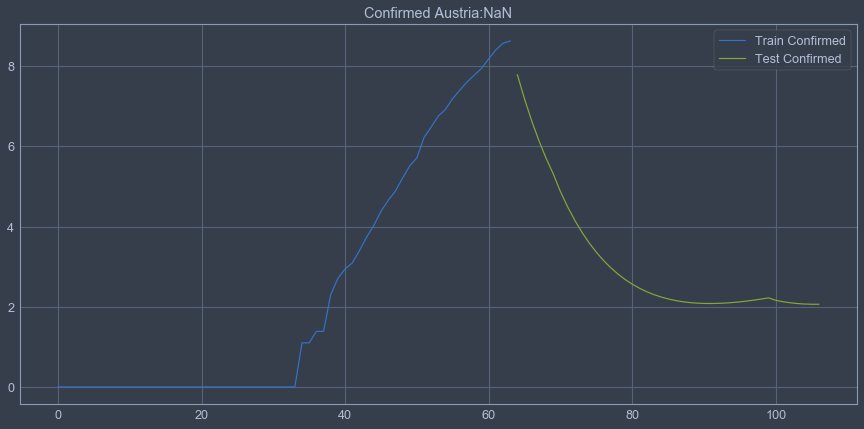

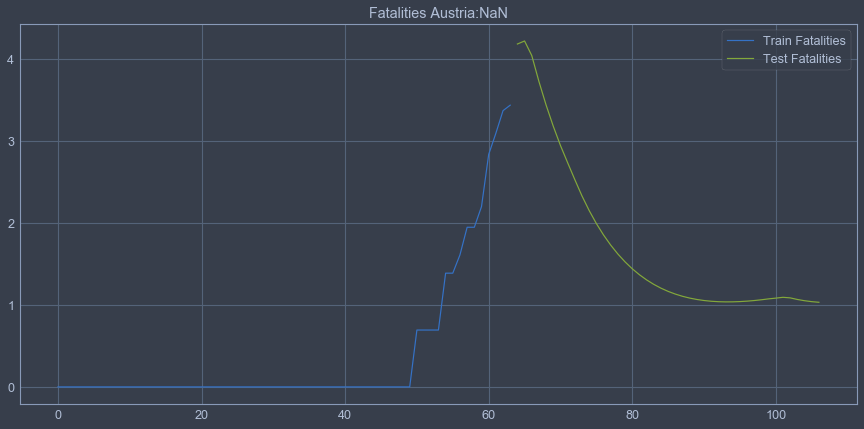

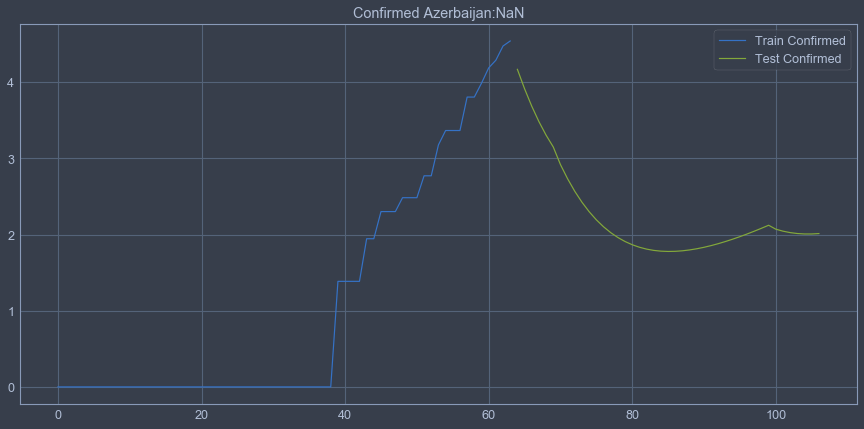

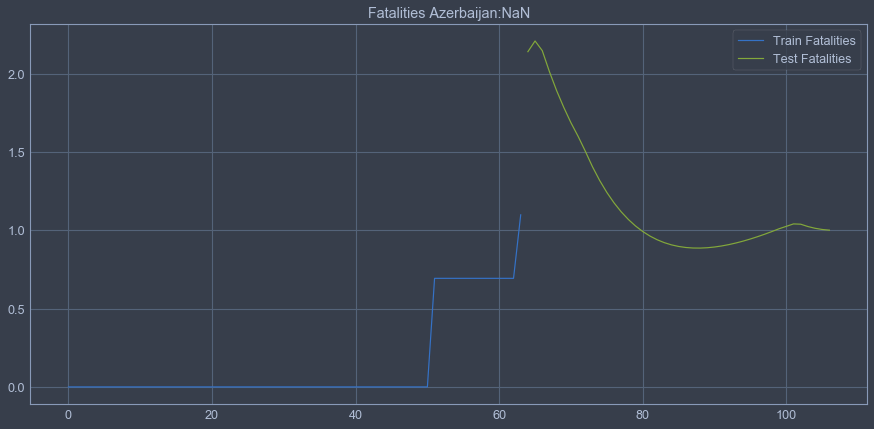

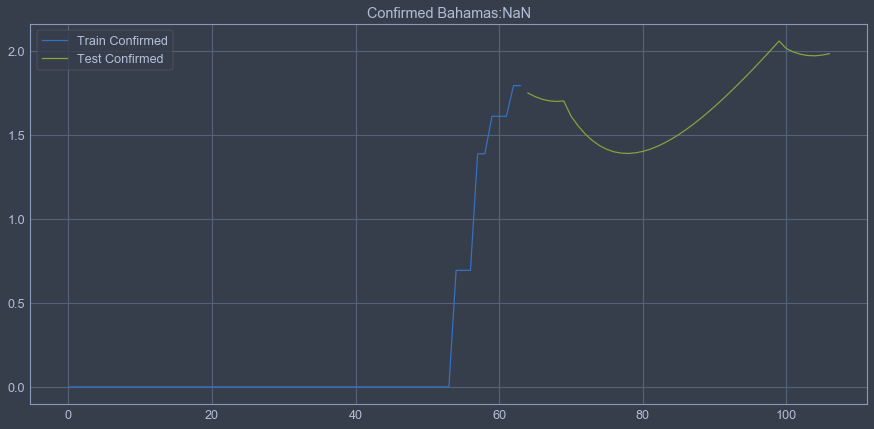

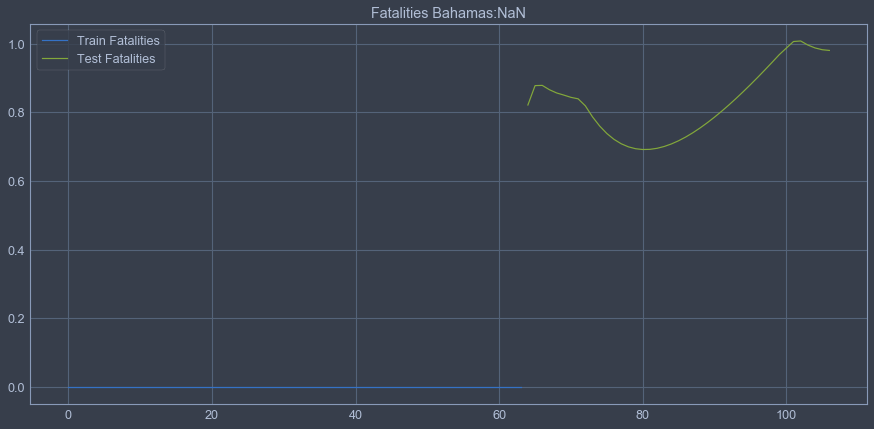

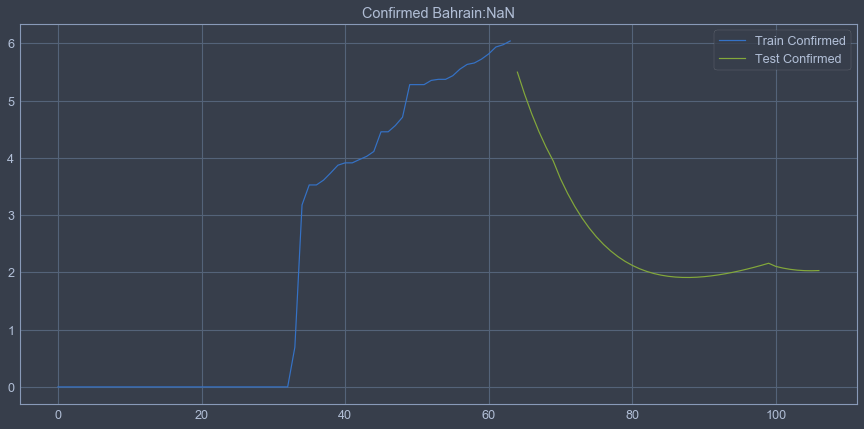

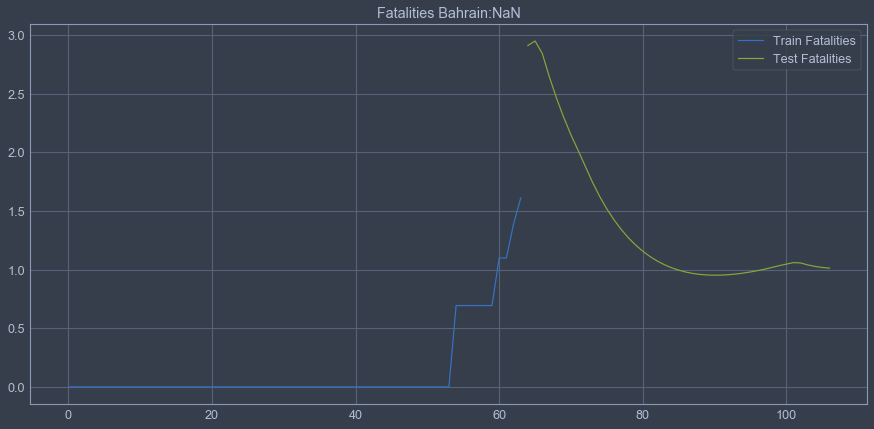

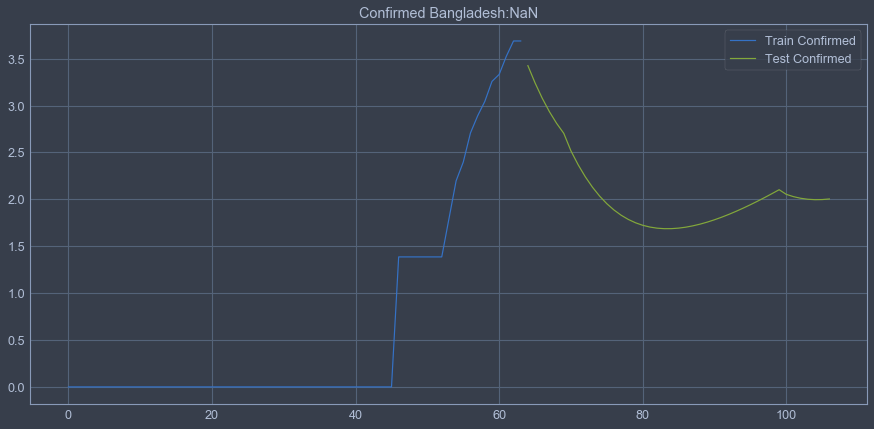

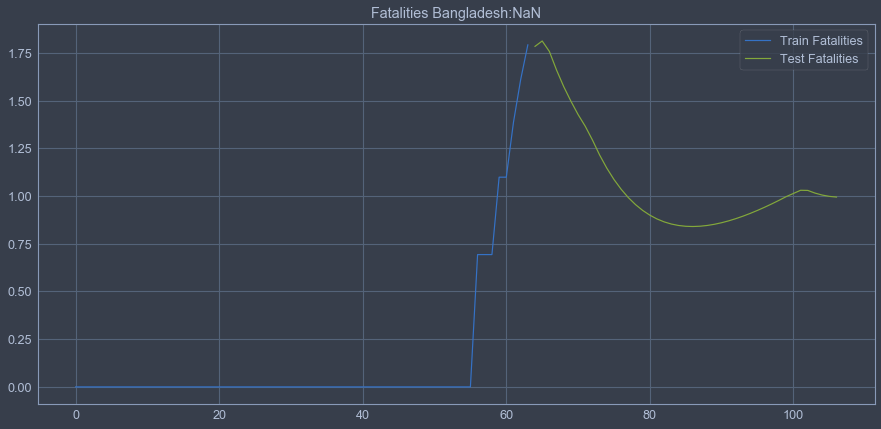

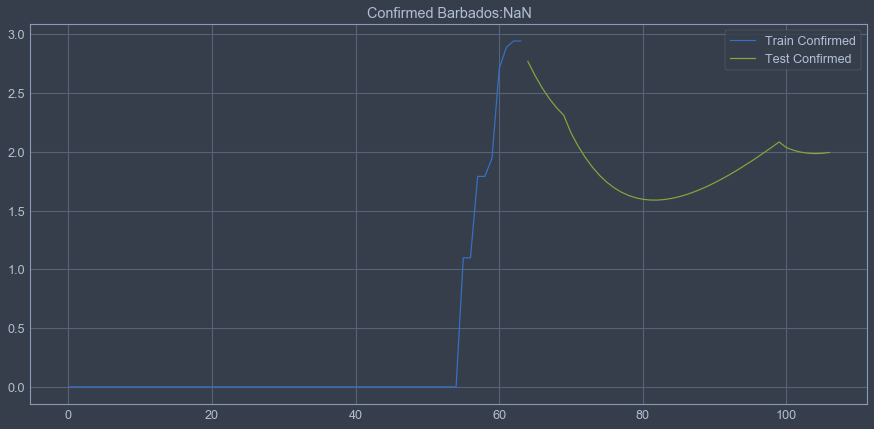

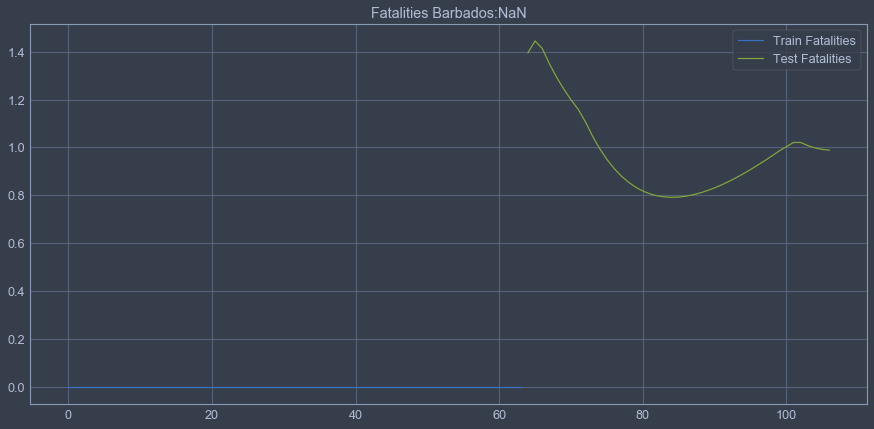

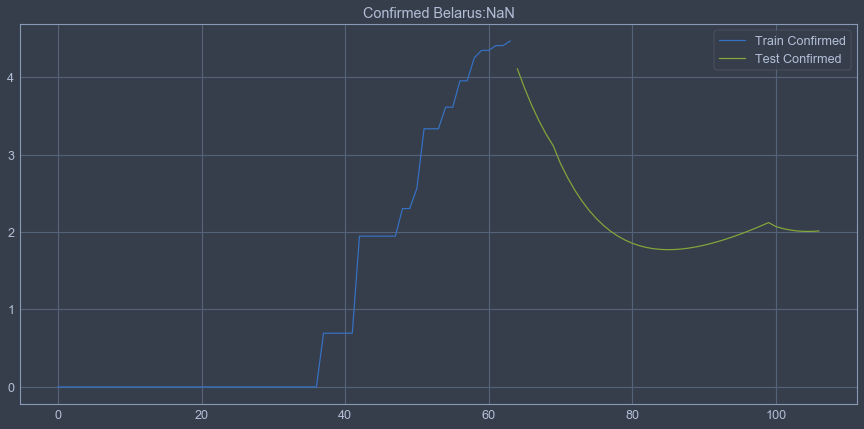

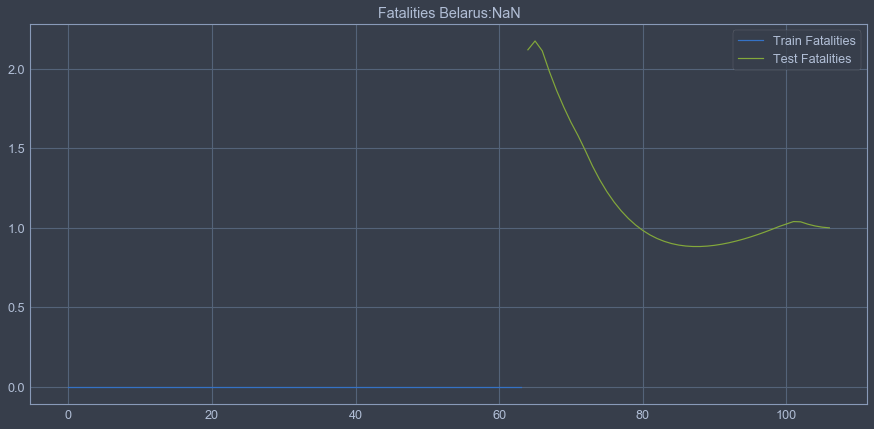

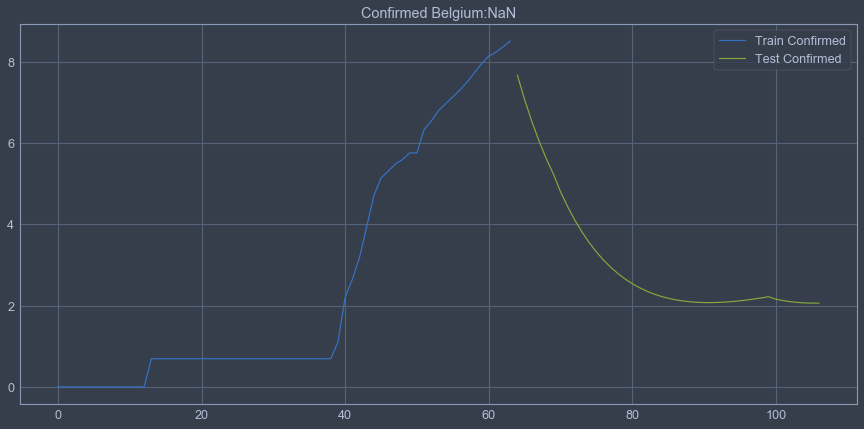

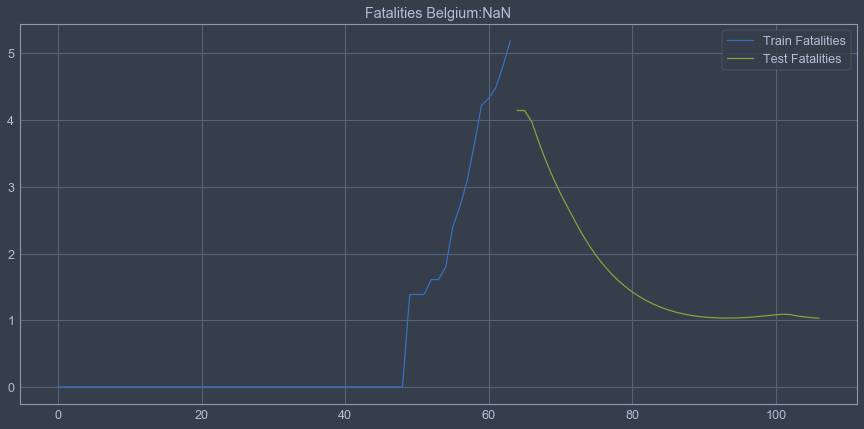

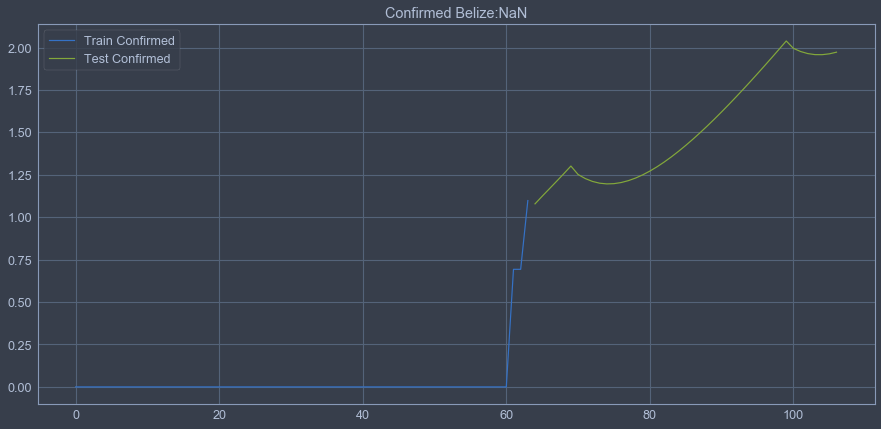

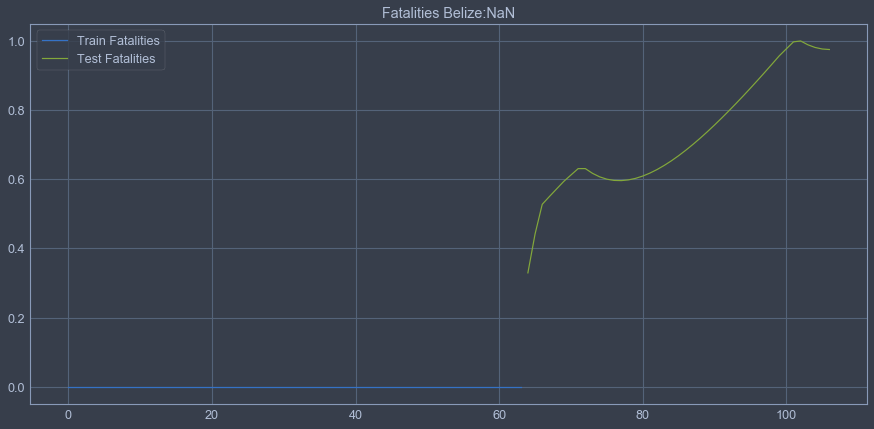

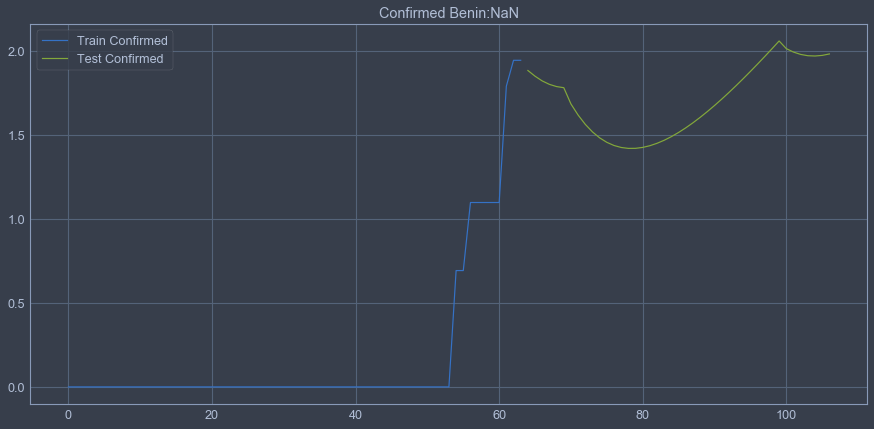

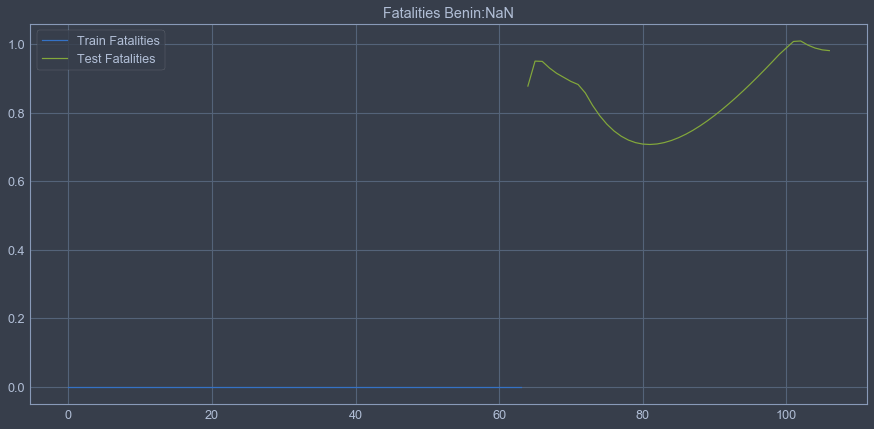

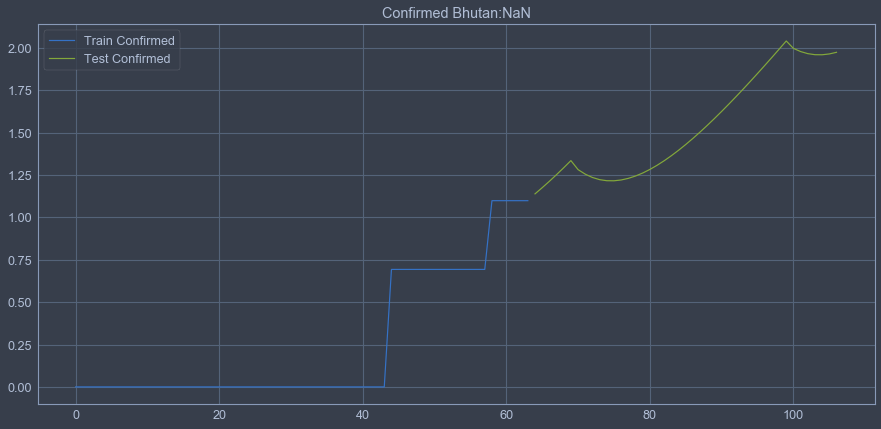

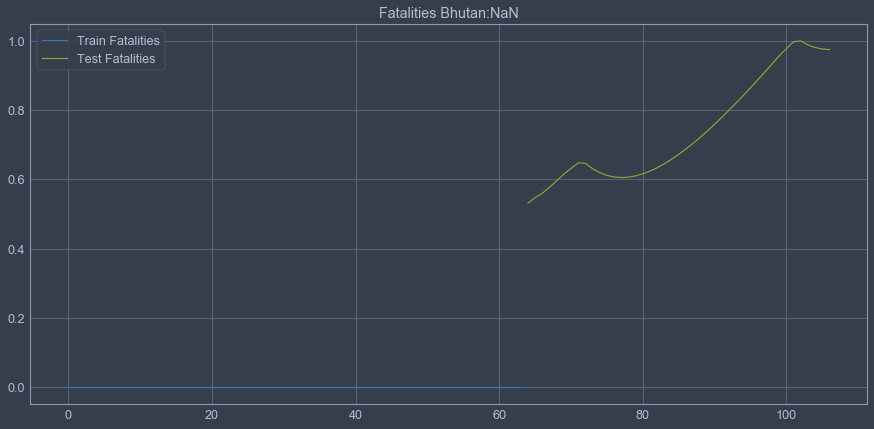

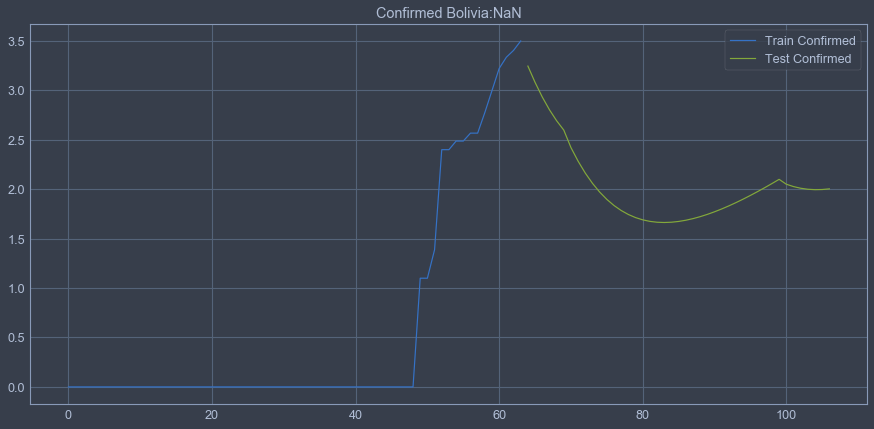

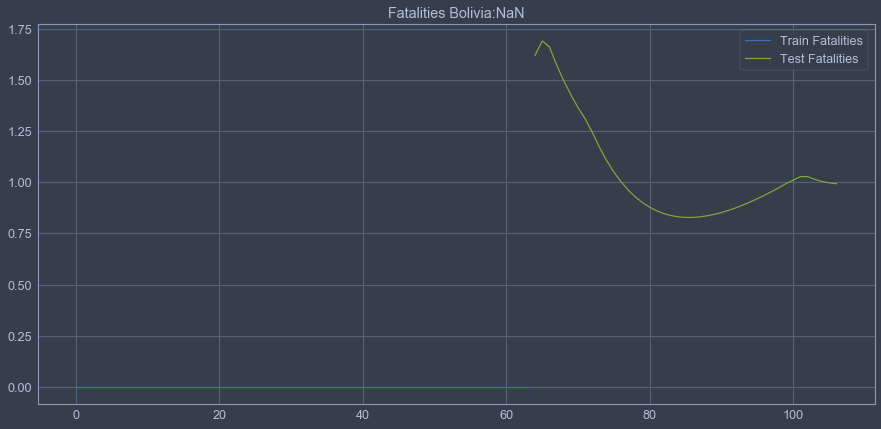

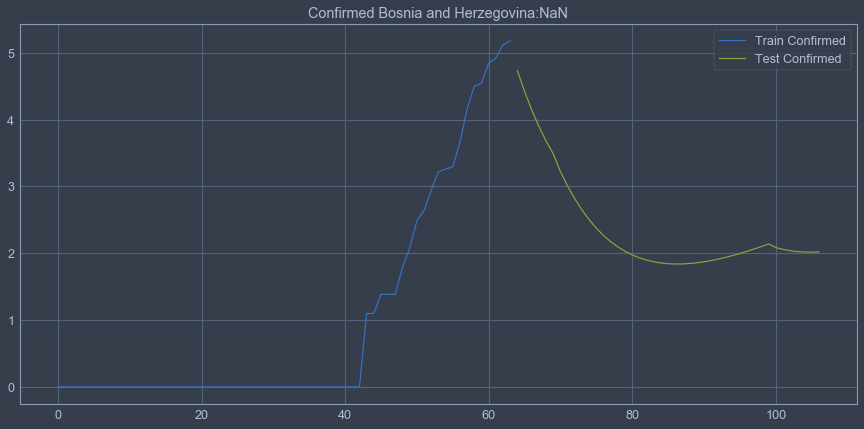

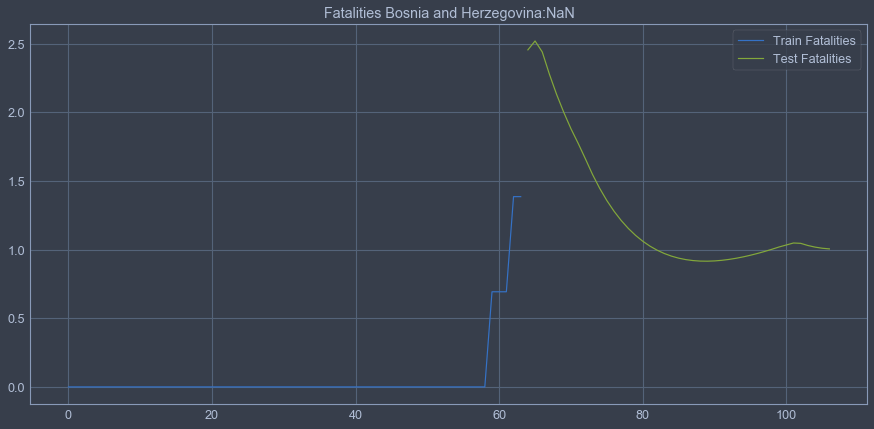

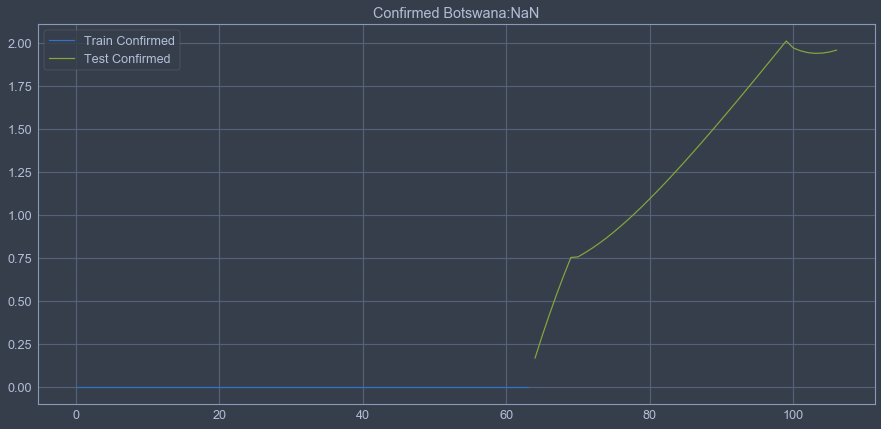

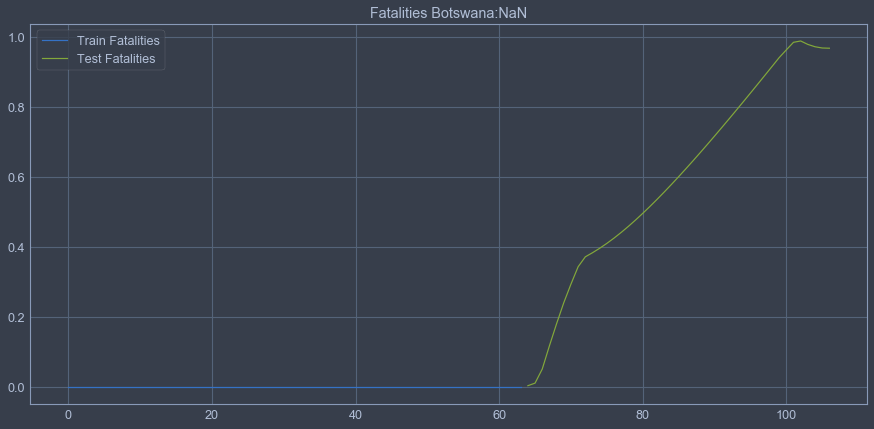

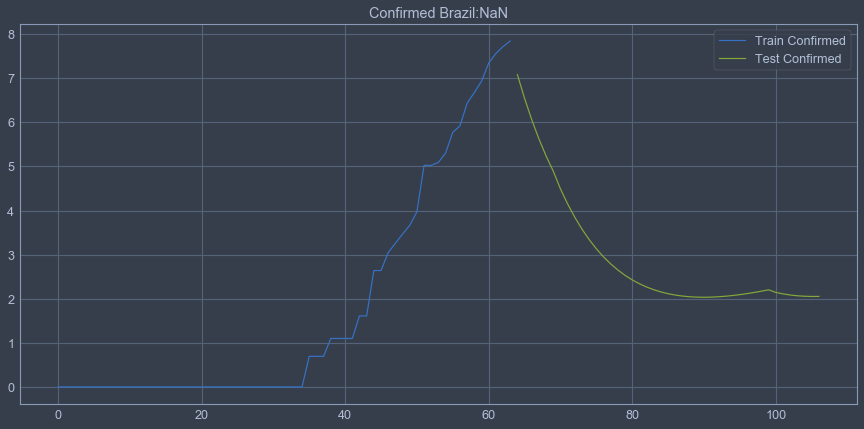

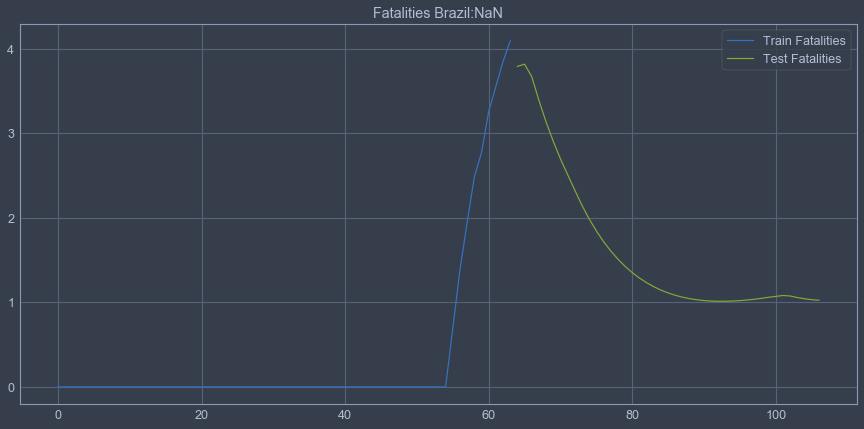

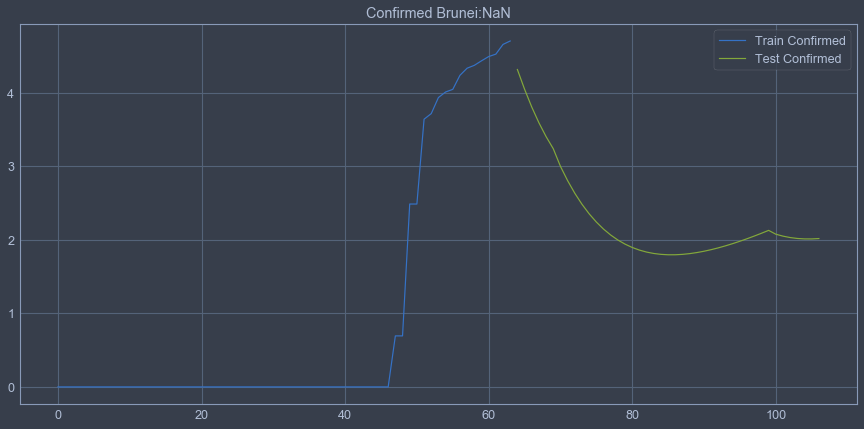

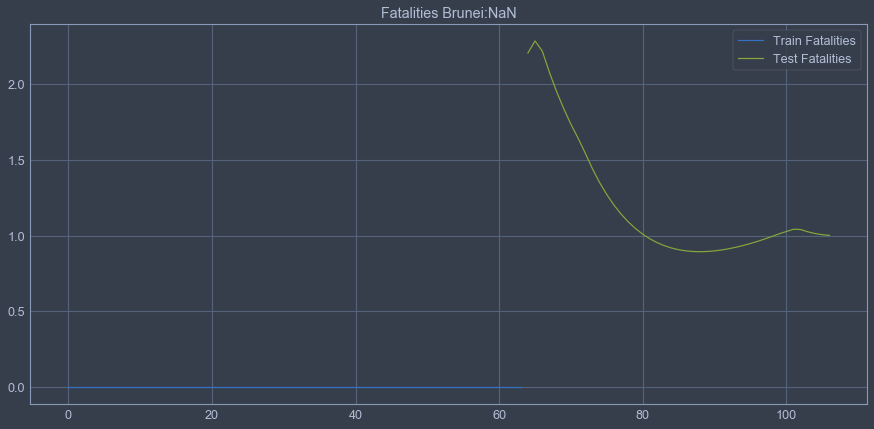

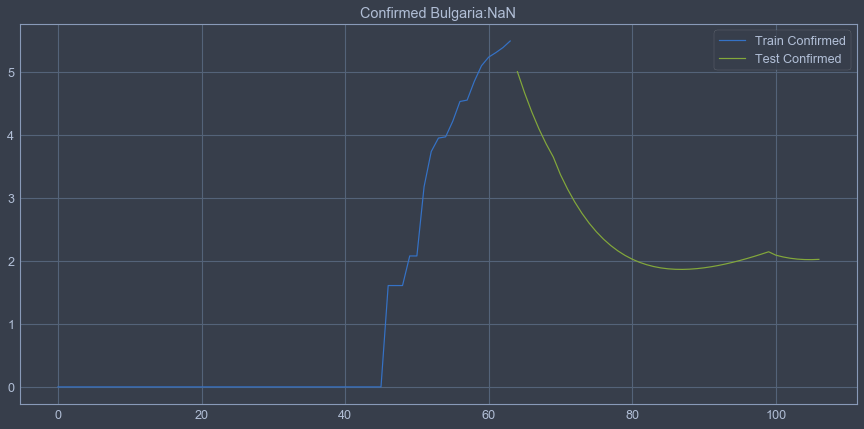

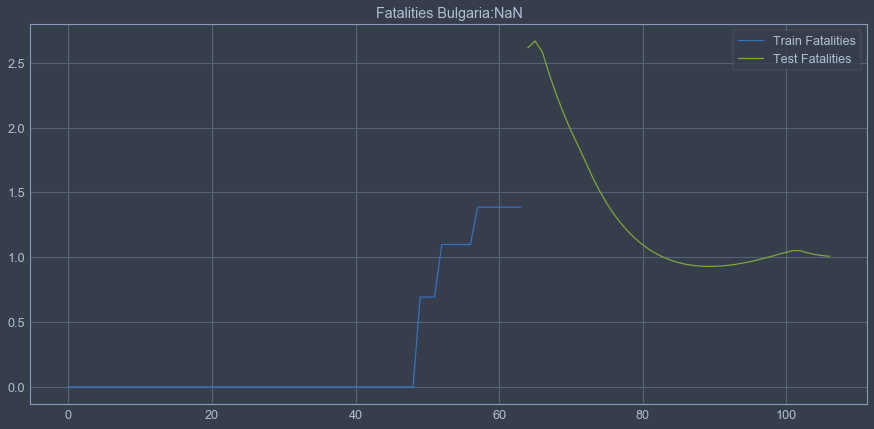

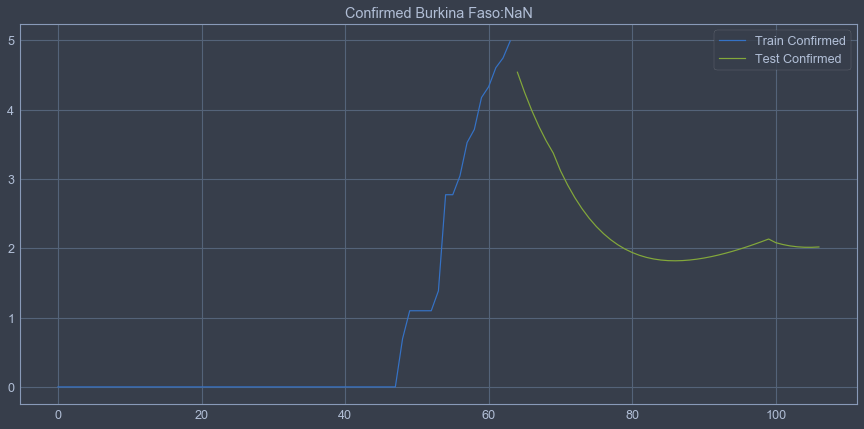

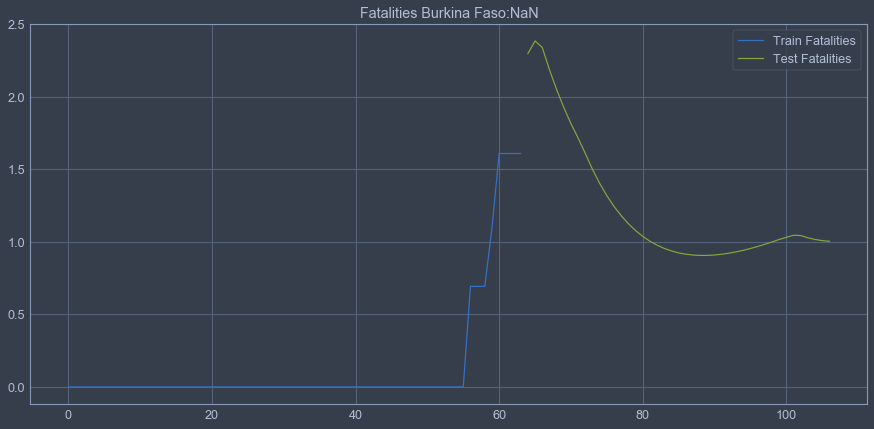

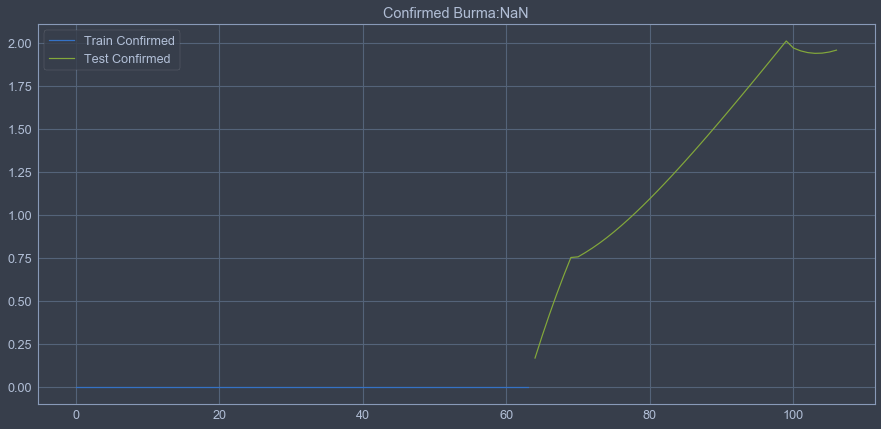

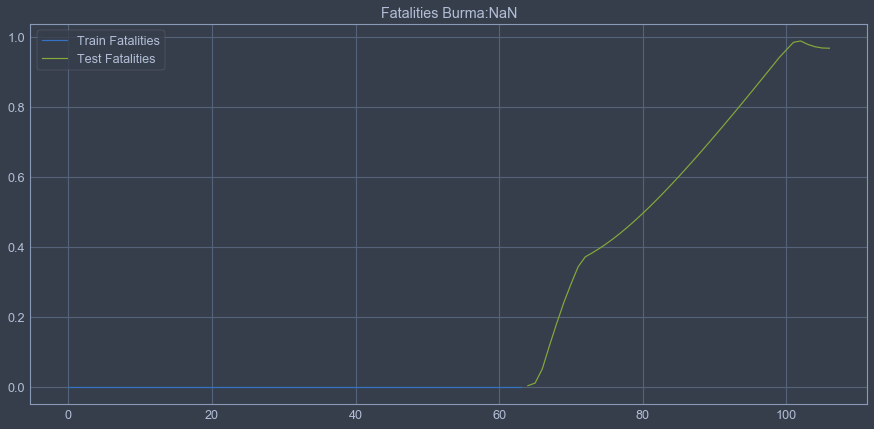

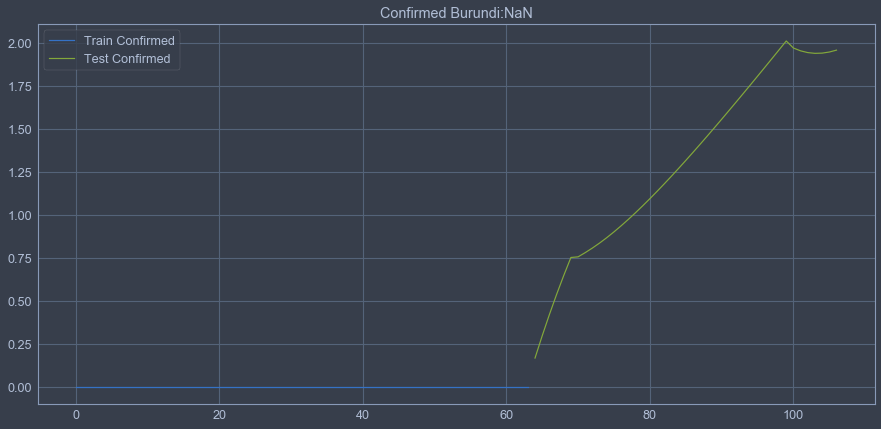

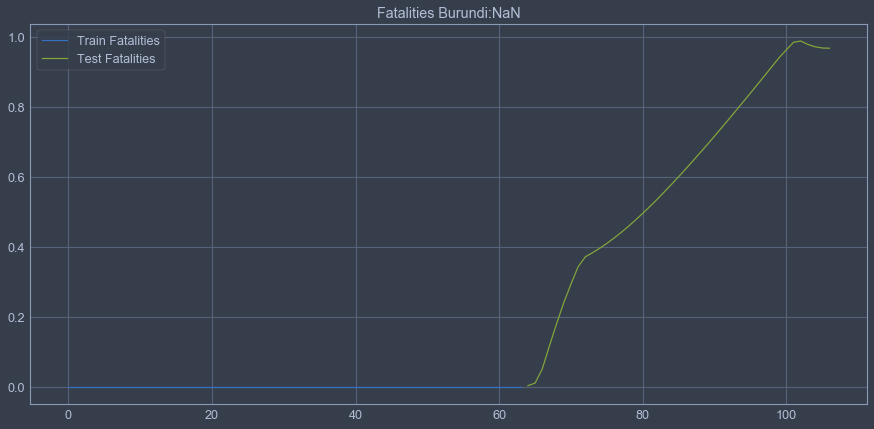

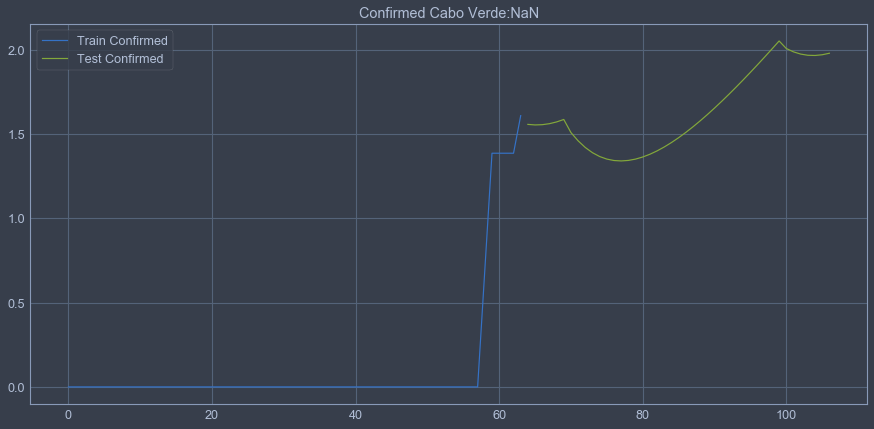

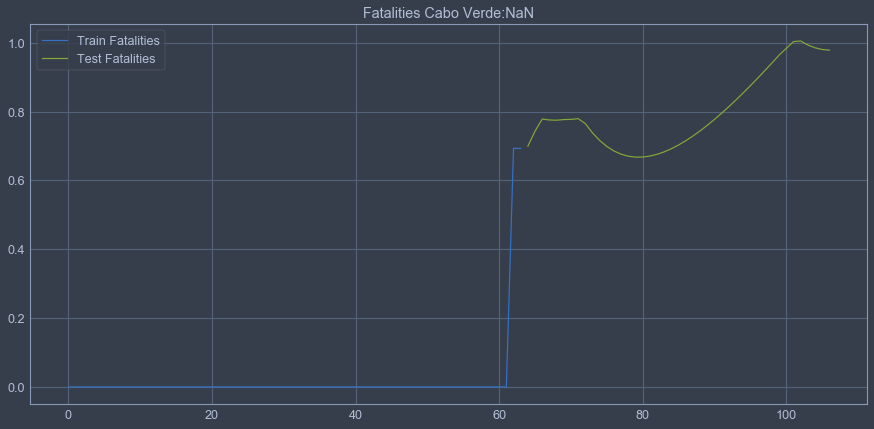

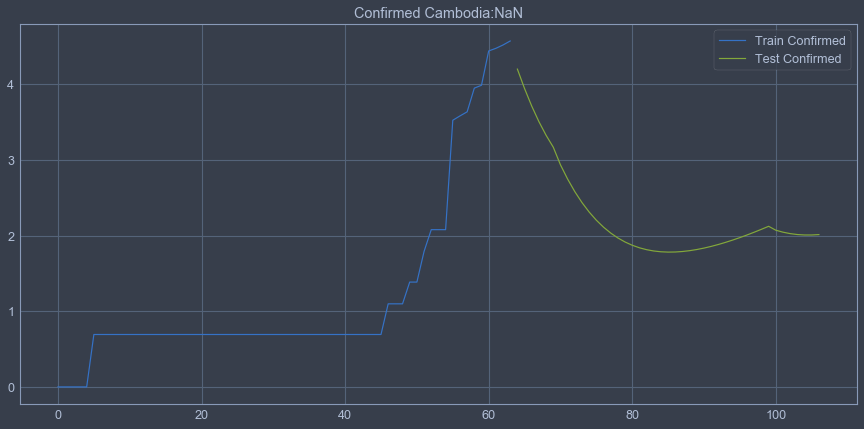

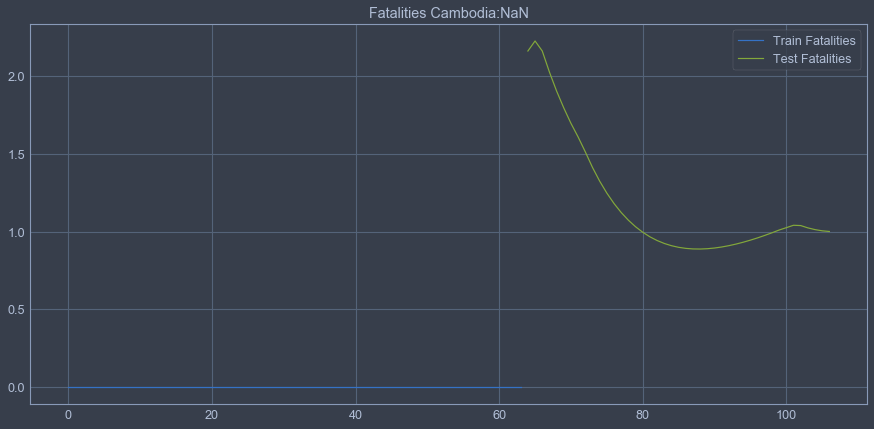

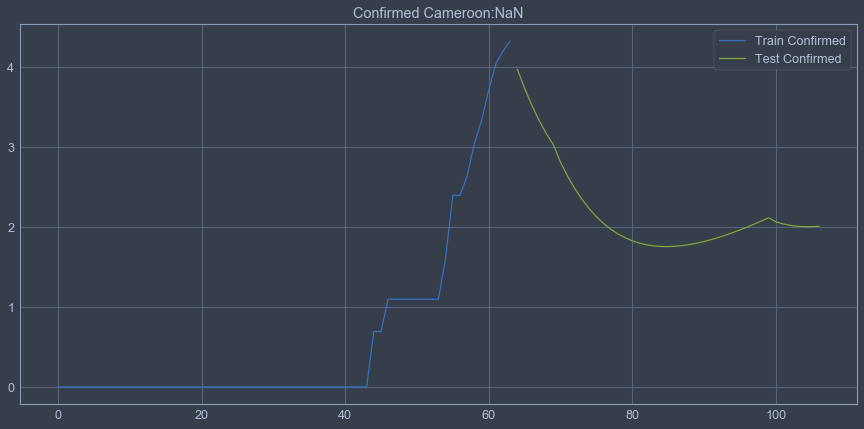

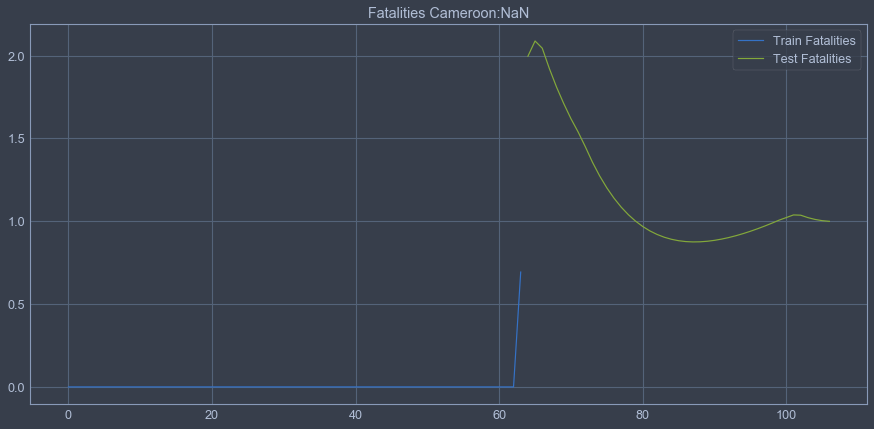

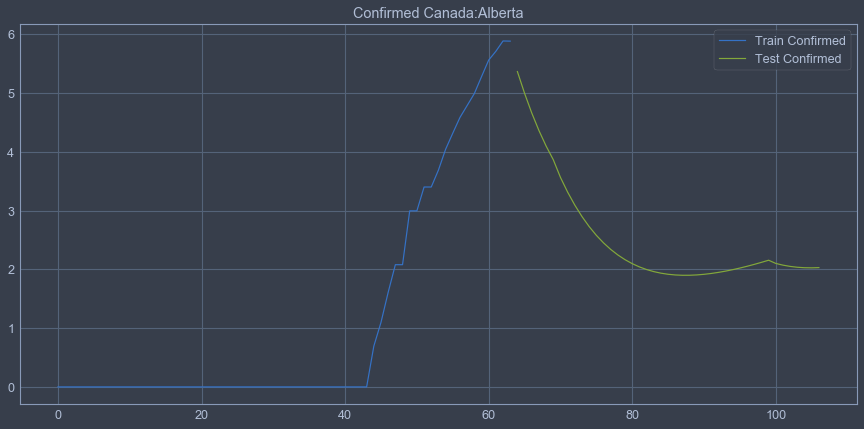

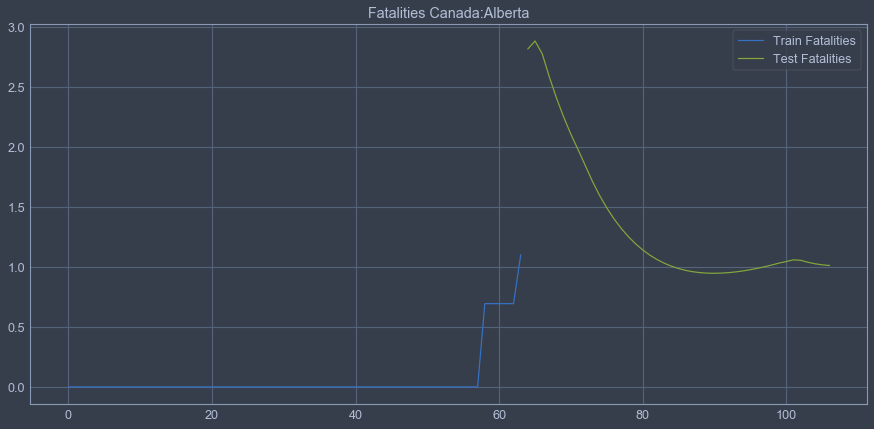

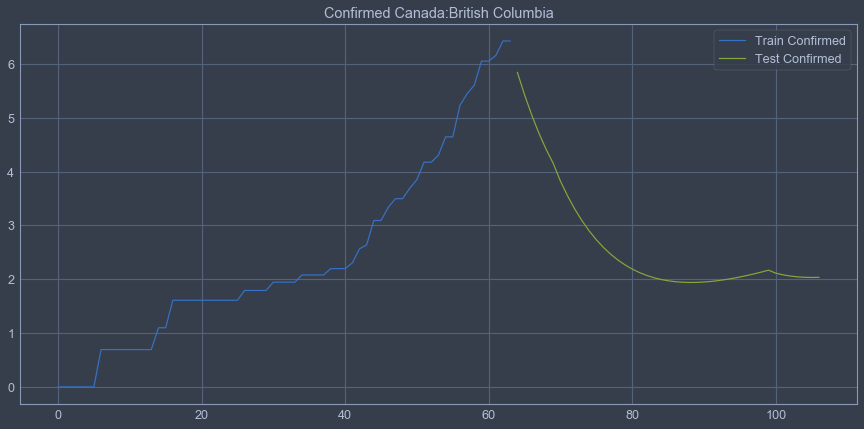

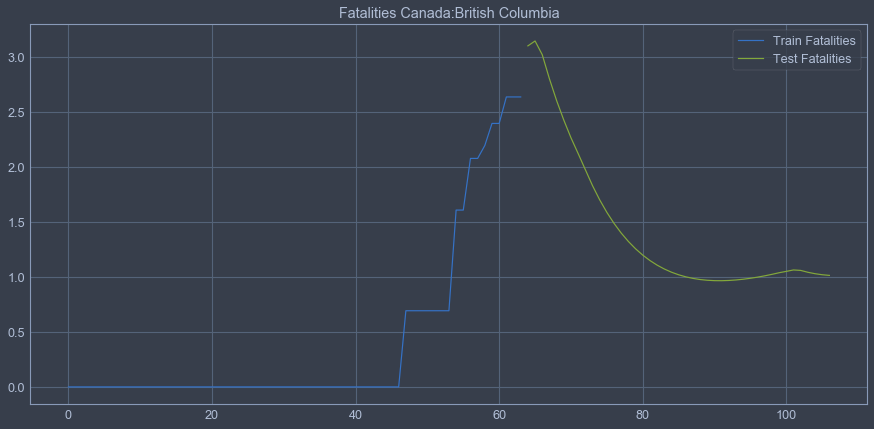

KeyboardInterrupt: 

In [43]:
# res = []
# for country in tqdm(data['Country_Region'].unique()):
#     country_df = data.loc[data['Country_Region'] == country]
#     for state in country_df['Province_State'].unique():
#         curr_state_mask = np.logical_and(data['Country_Region'] == country, data['Province_State'] == state)
#         curr_state_data = data.loc[curr_state_mask]
        
#         lags_data = lagging(curr_state_data[['ConfirmedCases', 'Fatalities']])
#         data_with_lags = pd.concat([curr_state_data, lags_data], axis=1).dropna()
#         state_train_mask = data_with_lags['ForecastId'] == -1
        
#         state_train_data = data_with_lags[state_train_mask]
#         state_test_data = data_with_lags[~state_train_mask]
        
#         submission_df = pd.DataFrame({'ForecastId': state_test_data['ForecastId']})
        
#         y_pred_conf, y_pred_fatal = predict(state_test_data, confirmed_model, fatalities_model)
        
#         submission_df['ConfirmedCases'] = np.expm1(y_pred_conf)
#         submission_df['Fatalities'] = np.expm1(y_pred_fatal)
#         submission_df.replace([np.inf, -np.inf], 0, inplace=True)
#         res.append(submission_df)
        
#         plt.figure(figsize=(15, 7))
#         plt.plot(state_train_data['Day_num'], state_train_data['ConfirmedCases'], label='Train Confirmed')
#         plt.plot(state_test_data['Day_num'],  y_pred_conf,  label='Test Confirmed')
#         plt.title(f'Confirmed {country}:{state}')
#         plt.legend()
#         plt.show()
#         i += 1
        
#         plt.figure(figsize=(15, 7))
#         plt.plot(state_train_data['Day_num'], state_train_data['Fatalities'], label='Train Fatalities')
#         plt.plot(state_test_data['Day_num'],  y_pred_fatal,  label='Test Fatalities')
#         plt.title(f'Fatalities {country}:{state}')
#         plt.legend()
#         plt.show()

In [ ]:
# submission = pd.concat(res, ignore_index=True)

In [ ]:
# submission.to_csv('mixed_models_submission.csv', index=False)

In [ ]:
# def linreg_basic_all_countries(data, day_start):
    
#     data2 = data.loc[data.Day_num >= day_start]

#     # Set the dataframe where we will update the predictions
#     data_pred = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
#     data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
#     data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
#     data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

#     print("Currently running Logistic Regression for all countries")

#     # Main loop for countries
#     for c in data2['Country_Region'].unique():

#         # List of provinces
#         provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()

#         # If the country has several Province/State informed
#         if len(provinces_list)>1:
#             for p in provinces_list:
#                 data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
#                 X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
#                 model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
#                 model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
#                 data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
#                 data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

#         # No Province/State informed
#         else:
#             data_c = data2[(data2['Country_Region']==c)]
#             X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
#             model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
#             model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
#             data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
#             data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

#     # Apply exponential transf. and clean potential infinites due to final numerical precision
#     data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
#     data_pred.replace([np.inf, -np.inf], 0, inplace=True) 
    
#     return data_pred


# day_start = 45
# data_pred = linreg_basic_all_countries(data, day_start)
# get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

# print("Process finished in ", round(time.time() - ts, 2), " seconds")

In [ ]:
# def timeseries_train_test_split(X, y, test_size):
#     """
#         Perform train-test split with respect to time series structure
#     """
    
#     # get the index after which test set starts
#     test_index = int(len(X)*(1-test_size))
    
#     X_train = X.iloc[:test_index]
#     y_train = y.iloc[:test_index]
#     X_test = X.iloc[test_index:]
#     y_test = y.iloc[test_index:]
    
#     return X_train, X_test, y_train, y_test

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# def timeseriesCVscore(model, X, y, n_splits, loss_function):
#     """
#         Returns error on CV  
        
#         params - vector of parameters for optimization
#         series - dataset with timeseries
#         slen - season length for Holt-Winters model
#     """
#     # errors array
#     errors = []

    
#     # set the number of folds for cross-validation
#     tscv = TimeSeriesSplit(n_splits=n_splits) 
    
#     # iterating over folds, train model on each, forecast and calculate error
#     for train, test in tscv.split(X, y):
#         start_time = time.time()
#         model = model.fit(X[train], y[train])
#         fit_time = time.time() - start_time
        
#         y_pred = model.predict(X[test])
#         y_true = y[test]
#         error = loss_function(y_pred, y_true)
#         score_time = time.time() - start_time - fit_time
#         errors.append(error)
        
#         cv_results['train_score'].append()
#         cv_results['test_score'].append(error)
    
#     res
#     return np.mean(np.array(errors))